# Model Evaluation

## Configuration file

In [57]:
configuration = 'training.yaml'
num_hours_for_normal_traffic = 12

In [58]:
import os, sys
src_dir = os.environ['BASKERVILLE_ROOT'] + '/src'
if not os.path.lexists(src_dir):
    raise RuntimeError('Baskerville source dir does not exist!')
module_path = os.path.abspath(os.path.join(src_dir))
if module_path not in sys.path:
    sys.path.append(module_path)
print(src_dir)

/home/spark/baskerville/src


In [59]:
from pyspark import SparkConf
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, StructField, StructType, DoubleType
from pyspark.sql import SparkSession
conf = SparkConf()
# conf.set('spark.driver.host', 'localhost' )
# conf.set('spark.master', 'local[10]')

conf.set('spark.driver.host', 'localhost' )
conf.set('spark.master', 'local[10]')
# spark://$SPARK_MASTER_HOST:7077
        
conf.set("spark.hadoop.dfs.client.use.datanode.hostname", True)
conf.set('spark.jars', os.environ['BASKERVILLE_ROOT'] + '/data/jars/postgresql-42.2.4.jar')
conf.set('spark.executor.memory', '40G')
conf.set('spark.memory.offHeap.enabled', 'true')
conf.set('spark.memory.offHeap.size', '35G')

# conf.set('parallelism', -1)

spark = SparkSession \
    .builder.config(conf=conf) \
    .appName("NotebookModelEvaluation") \
    .getOrCreate()

In [60]:
from baskerville.db.models import Attack, Attribute
from baskerville.util.helpers import parse_config
from baskerville.models.config import BaskervilleConfig
from baskerville.util.baskerville_tools import BaskervilleDBTools
from baskerville.models.anomaly_model import AnomalyModel
import time
from datetime import datetime, timedelta
import itertools
os.environ['TZ'] = 'UTC'
time.tzset()
conf_path = os.environ['BASKERVILLE_ROOT'] + f'/conf/{configuration}'
config = parse_config(path=conf_path)
config = BaskervilleConfig(config)
# features = config.engine.extra_features

# config.database.maintenance = None
# db_tools = BaskervilleDBTools(config.database)
# db_tools.connect_to_db()

In [61]:
from pyspark.sql.types import *
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from baskerville.db import get_jdbc_url

def load_dataset(query, spark, db_config):
    db_url = get_jdbc_url(db_config)
    conn_properties = {
        'user': db_config.user,
        'password': db_config.password,
        'driver': 'org.postgresql.Driver',
    }
    df = spark.read.jdbc(
            url=db_url,
            table=query,
            properties=conn_properties
        )
#     df = df.limit(100)
    json_schema = spark.read.json(df.limit(1).rdd.map(lambda row: row.features)).schema
#     json_schema.add(StructField(
#         name='host_country',
#         dataType=StringType(),
#         nullable=True))
    df = df.withColumn('features1', F.from_json('features', json_schema))
    df = df.withColumn('features', F.create_map(
        *list(itertools.chain(*[(F.lit(f), F.col('features1').getItem(f)) for f in json_schema.__dict__['names']])
             ))).drop('features1')
    
#     df = df.withColumn('features.host_country', F.concat(F.col("features.host"), F.lit("_"), F.col("features.country")))

    return df

def evaluate_model(models, spark, db_config):
    config.database.maintenance = None
    db_tools = BaskervilleDBTools(db_config)
    db_tools.connect_to_db()

    attacks = db_tools.session.query(Attack).all()
    result = []
    for attack in attacks:
        if attack.id < 21:
            continue
            
#         if attack.id != 9: # losdanieles
#             continue
#         if attack.id != 10: # balochcampaign jule 9
#             continue
            
        print(f'Processing attack {attack.id}: target={attack.target}, start={attack.start}, stop={attack.stop}')
        
        if attack.id == 9: # losdanieles manually filtered by Vladimir
            attack_ips = ['101.109.188.190','101.109.246.40','101.109.255.48','101.200.127.149','101.255.122.73','101.99.7.167','102.130.114.107','102.130.133.102','102.141.197.17','102.164.203.237','102.164.248.60','102.176.160.82','102.176.160.84','102.177.105.34','102.38.50.10','102.67.19.132','102.68.134.32','102.68.134.33','102.68.134.34','102.68.134.35','102.68.134.36','102.68.134.37','102.68.134.38','102.68.134.39','102.68.134.40','102.68.134.41','102.68.134.42','102.68.134.43','102.68.134.44','102.68.134.45','102.68.134.46','102.68.134.47','102.68.134.48','102.68.134.49','102.68.134.50','102.68.134.51','102.68.134.52','102.68.134.53','102.68.134.54','102.68.134.55','102.68.134.56','102.68.134.57','102.68.134.58','102.68.134.59','102.68.134.60','102.68.134.61','102.68.134.62','102.68.134.63','102.68.135.32','102.68.135.33','102.68.135.34','102.68.135.35','102.68.135.36','102.68.135.37','102.68.135.38','102.68.135.39','102.68.135.40','102.68.135.41','102.68.135.42','102.68.135.43','102.68.135.44','102.68.135.45','102.68.135.46','102.68.135.47','102.68.135.48','102.68.135.49','102.68.135.50','102.68.135.51','102.68.135.52','102.68.135.53','102.68.135.54','102.68.135.55','102.68.135.56','102.68.135.57','102.68.135.58','102.68.135.59','102.68.135.60','102.68.135.61','102.68.135.62','102.68.135.63','102.68.17.96','103.101.17.170','103.101.233.13','103.101.83.54','103.105.125.6','103.105.212.106','103.10.54.154','103.10.81.138','103.109.238.250','103.109.59.126','103.111.219.183','103.112.212.194','103.112.58.38','103.114.10.250','103.116.250.78','103.119.230.245','103.120.188.180','103.121.149.46','103.12.161.194','103.122.35.229','103.123.171.2','103.123.231.202','103.123.246.66','103.125.107.220','103.130.112.250','103.130.172.58','103.130.187.98','103.133.222.151','103.134.226.166','103.136.25.43','103.138.226.115','103.138.226.2','103.139.156.122','103.14.111.218','103.14.198.14','103.142.110.130','103.142.68.149','103.142.68.150','103.142.68.154','103.142.68.157','103.142.68.158','103.143.157.42','103.143.84.72','103.146.203.237','103.147.68.251','103.148.195.11','103.148.79.3','103.15.240.89','103.15.60.21','103.16.133.11','103.199.85.58','103.201.140.6','103.20.204.104','103.204.220.18','103.204.220.23','103.208.152.34','103.208.200.114','103.209.131.3','103.209.65.12','103.21.160.10','103.212.92.254','103.216.48.83','103.216.51.210','103.21.93.235','103.220.214.106','103.221.254.125','103.224.38.22','103.227.145.90','103.228.117.244','103.233.152.140','103.233.154.245','103.239.254.114','103.240.161.108','103.245.198.101','103.247.122.102','103.248.13.85','103.250.166.16','103.250.166.4','103.250.69.233','103.251.225.18','103.251.57.23','103.252.117.100','103.26.246.126','103.26.54.94','103.26.55.86','103.28.149.107','103.36.35.131','103.36.48.103','103.36.8.202','103.4.164.205','103.42.162.30','103.42.253.210','103.44.156.62','103.46.233.186','103.47.66.150','103.47.66.42','103.47.67.115','103.47.67.116','103.47.67.123','103.52.144.242','103.53.76.82','103.57.121.132','103.65.26.203','103.66.47.126','103.70.129.130','103.70.145.211','103.70.145.84','103.70.79.2','103.7.27.186','103.76.20.155','103.78.23.26','103.81.214.254','103.81.77.11','103.82.43.118','103.83.118.10','103.86.155.78','103.86.49.193','103.87.160.4','103.91.128.126','103.95.40.211','103.9.88.203','103.99.10.3','103.99.26.2','103.99.8.102','103.99.8.106','104.151.207.71','104.196.240.190','104.196.241.222','104.199.114.40','104.232.196.249','104.238.53.159','104.244.72.99','104.244.73.43','104.244.74.57','104.244.74.97','104.244.75.26','104.244.76.13','104.244.76.245','104.244.77.254','104.248.49.76','105.112.8.53','107.0.255.90','107.77.203.26','107.77.233.71','108.27.220.78','109.167.207.72','109.170.97.146','109.188.74.95','109.199.133.161','109.200.156.102','109.207.94.234','109.251.185.20','109.41.66.89','110.170.254.50','1.10.188.132','1.10.188.140','1.10.188.202','1.10.188.85','110.232.74.51','110.34.3.145','110.36.237.123','110.44.133.135','110.74.219.3','110.76.148.242','110.77.134.106','110.78.147.134','110.78.81.107','110.93.214.36','111.118.154.20','111.67.92.66','111.68.118.121','111.92.240.134','112.109.198.105','1.1.228.77','113.130.126.212','113.160.235.49','113.161.186.101','113.161.58.255','113.163.157.250','113.185.0.13','113.196.140.162','113.53.255.222','113.53.29.218','113.53.53.138','113.53.61.123','113.53.83.157','113.53.83.212','113.53.8.35','113.53.91.214','114.31.15.62','114.4.102.78','114.5.24.14','114.5.35.98','115.127.114.76','115.74.213.139','115.84.99.82','115.85.65.94','116.0.2.162','116.196.85.150','116.197.129.242','116.197.133.90','116.197.134.222','116.203.254.70','116.206.47.10','116.212.109.195','116.212.129.58','116.212.152.64','116.58.254.148','116.66.197.210','116.66.197.228','117.102.105.91','117.102.127.130','117.102.77.3','117.102.78.42','117.103.168.18','117.103.5.186','117.211.203.210','117.2.121.203','117.220.198.251','117.240.238.230','117.4.245.210','117.54.239.18','117.54.4.244','117.58.241.70','1.179.144.181','118.163.13.200','118.172.176.61','118.173.232.219','118.174.196.112','118.174.232.106','118.174.232.243','118.174.233.40','118.175.207.183','118.175.244.111','118.179.119.218','1.186.151.206','118.69.56.68','118.97.100.83','118.97.164.19','118.97.22.203','119.15.82.222','119.15.89.106','119.252.160.165','119.252.161.110','119.252.168.53','119.40.93.26','119.82.242.124','1.20.156.230','1.20.217.221','120.28.57.114','120.29.124.131','120.76.116.167','1.20.97.96','121.52.71.23','12.156.45.155','121.58.246.247','1.2.174.219','122.102.28.160','122.154.72.102','122.200.90.10','122.2.28.114','122.248.45.35','1.2.254.185','122.54.227.188','122.55.250.242','1.229.137.26','123.1.170.138','123.132.232.254','123.139.56.238','123.231.171.11','123.231.239.178','124.105.197.141','124.106.57.182','124.158.154.66','124.158.175.19','124.158.175.2','124.158.175.26','124.41.211.196','124.41.213.211','124.41.240.43','124.6.226.21','124.93.201.59','12.5.154.134','125.16.131.29','125.20.80.178','125.209.235.169','125.209.235.170','125.209.235.175','125.25.206.28','125.25.227.147','125.25.40.37','125.25.80.39','125.26.219.13','125.26.7.114','125.26.7.83','125.27.251.206','125.27.251.24','1.255.48.197','128.199.149.7','128.199.151.20','128.31.0.13','129.205.98.54','131.108.84.14','131.196.202.105','131.196.87.117','131.196.9.216','131.255.186.65','13.231.63.81','134.236.247.137','134.249.167.184','136.243.1.83','136.243.81.120','13.68.172.219','137.220.38.141','137.59.161.46','137.63.184.96','138.121.91.159','138.122.140.18','138.201.248.12','138.201.5.34','138.255.36.199','138.59.25.2','138.68.236.159','139.180.135.7','139.217.110.76','139.228.177.168','139.255.115.139','139.255.13.153','139.255.17.170','139.255.25.106','139.255.31.210','139.255.36.34','139.255.48.164','139.255.74.125','139.255.89.242','139.5.132.245','139.5.71.80','139.99.105.5','139.99.61.158','139.99.90.123','139.99.90.186','140.238.15.65','140.238.17.59','140.82.36.154','140.82.37.12','141.0.180.242','14.102.61.138','14.162.145.116','14.207.12.199','14.207.24.155','14.207.42.220','14.207.60.81','14.225.5.68','142.44.169.101','14.249.164.224','142.93.130.169','142.93.197.142','143.255.142.80','143.255.52.102','144.217.108.11','144.217.166.65','144.91.88.108','144.91.88.111','145.239.121.218','145.239.7.56','146.120.175.22','147.78.160.1','147.78.160.138','147.78.160.192','147.78.160.237','147.78.160.45','147.78.161.119','147.78.161.158','147.78.161.16','147.78.161.169','147.78.161.173','147.78.161.59','147.78.161.94','147.78.161.99','148.251.16.142','148.251.162.204','148.251.56.230','148.251.56.232','149.129.240.8','149.202.238.204','150.107.205.196','150.107.207.137','150.129.250.28','150.129.54.111','150.129.56.138','150.129.8.10','150.129.8.11','150.129.8.12','150.129.8.13','150.129.8.14','150.129.8.15','150.129.8.16','150.129.8.17','150.129.8.23','150.129.8.24','150.129.8.26','150.129.8.27','150.129.8.28','150.129.8.29','150.129.8.30','150.129.8.31','150.129.8.34','150.129.8.4','150.129.8.5','150.129.8.6','150.129.8.7','150.129.8.8','150.129.8.9','151.22.180.54','151.80.237.96','152.204.132.123','152.204.163.30','153.142.70.170','154.0.4.110','154.113.69.154','154.117.143.126','154.120.65.198','154.236.162.58','154.66.125.18','154.73.159.253','156.155.136.11','157.230.155.18','159.192.131.178','159.192.132.220','159.192.140.232','159.192.142.42','159.192.148.58','159.203.44.177','159.203.82.173','159.224.83.100','160.119.44.210','160.119.45.111','161.18.9.253','161.35.15.102','161.38.11.86','162.216.17.140','162.231.236.140','162.247.72.199','162.247.73.192','162.247.74.200','162.247.74.201','162.247.74.204','163.172.125.41','163.172.143.1','163.172.198.72','163.172.202.103','163.172.202.247','163.172.211.204','163.172.60.116','163.172.63.172','163.172.98.140','163.172.98.147','163.172.98.148','163.172.98.153','163.53.185.98','163.53.198.54','163.53.209.7','164.115.22.45','164.132.51.91','164.132.98.80','164.39.202.75','165.16.25.42','165.16.96.92','165.22.211.212','165.22.213.55','165.227.201.107','165.98.139.28','167.0.132.17','167.0.141.192','167.0.82.233','167.233.7.67','167.249.181.19','167.71.238.159','167.71.249.181','167.88.7.134','167.99.226.100','168.138.142.54','168.181.196.71','168.228.193.214','168.228.204.253','168.228.51.238','168.232.20.155','168.90.30.182','169.159.130.182','169.255.126.211','169.255.234.166','170.233.164.192','170.238.236.98','170.81.35.26','170.82.52.48','17.142.157.106','17.142.157.79','171.97.131.30','172.104.11.250','172.104.140.63','172.58.143.39','172.58.203.100','172.58.227.177','173.239.53.9','173.244.209.5','173.252.87.20','173.82.17.187','173.82.17.188','173.82.17.189','173.82.17.190','173.82.62.19','173.82.62.20','173.82.74.60','173.82.74.62','173.82.78.188','173.82.78.189','173.82.78.190','174.193.15.168','175.100.16.20','175.100.73.206','175.106.11.44','175.158.62.142','176.10.107.180','176.103.55.36','176.10.40.102','176.112.157.11','176.115.197.118','176.116.57.51','176.117.126.22','176.120.221.115','176.123.7.19','176.123.9.61','176.192.8.206','176.197.145.162','176.235.99.114','176.30.212.194','176.32.185.22','176.98.76.203','176.99.4.126','176.99.6.196','176.99.9.44','177.10.193.100','177.10.232.124','177.104.82.220','177.124.184.52','177.125.169.6','177.126.81.62','177.128.42.18','177.137.203.179','177.152.143.74','177.155.215.89','177.170.20.74','177.184.140.130','177.200.206.167','177.202.59.58','177.220.188.213','177.22.203.220','177.222.248.168','177.254.19.208','177.255.232.143','177.38.243.102','177.43.217.74','177.43.72.251','177.44.82.232','177.47.181.240','177.55.207.37','177.71.77.202','177.73.170.165','177.74.252.191','177.75.198.61','177.75.8.146','177.8.113.61','177.8.216.114','177.91.72.22','177.99.162.131','177.99.206.82','178.132.220.241','178.151.178.218','178.151.34.43','178.159.40.19','178.16.125.74','178.162.194.7','178.17.170.116','178.17.170.13','178.205.254.106','178.208.131.67','178.210.129.150','178.210.129.228','178.214.12.140','178.215.190.240','178.216.2.229','178.219.118.156','178.238.232.35','178.238.41.102','178.238.41.103','178.238.41.75','178.238.41.79','178.250.92.18','178.32.223.164','178.33.251.230','178.63.105.157','178.63.105.159','178.63.105.161','178.63.105.162','178.63.41.235','178.79.24.36','179.108.81.76','179.12.244.100','179.13.184.8','179.13.87.204','179.14.149.79','179.15.102.143','179.15.149.57','179.15.247.218','179.154.142.141','179.15.92.94','179.1.82.158','179.18.37.221','179.18.48.174','179.189.125.222','179.189.226.186','179.189.27.28','179.222.91.112','179.32.142.178','179.32.217.157','179.33.39.253','179.43.167.229','179.49.117.36','179.49.117.40','179.49.117.41','179.49.117.42','179.49.117.43','179.49.117.45','179.51.112.19','179.51.114.102','179.51.119.60','179.95.235.138','179.97.55.94','180.148.4.194','180.149.96.133','180.178.102.174','180.179.98.22','180.180.170.188','180.180.171.123','180.180.8.34','180.183.1.184','180.183.8.243','180.211.183.178','180.211.186.90','180.211.193.214','180.242.154.60','180.248.254.126','180.250.162.3','180.250.180.66','180.250.216.242','180.250.49.138','180.94.64.114','181.10.129.85','181.10.160.155','181.113.139.197','181.113.225.114','181.114.226.40','181.114.226.44','181.115.38.146','181.118.105.234','181.118.167.73','181.129.103.210','181.129.142.90','181.129.163.74','181.129.165.102','181.129.174.155','181.129.185.132','181.129.217.53','181.129.70.82','181.129.98.146','181.131.134.213','181.132.96.231','181.133.251.222','181.133.96.190','181.136.83.107','181.136.91.93','181.137.198.150','181.139.235.79','181.140.166.162','181.143.123.118','181.143.73.34','181.148.164.226','181.149.243.210','181.154.190.243','181.155.181.39','181.157.46.146','181.168.206.106','181.176.161.39','181.191.180.110','181.192.2.23','181.197.190.201','181.199.38.102','181.225.73.2','181.225.73.229','181.234.163.73','181.234.167.200','181.236.183.5','181.236.228.127','181.236.232.50','181.243.103.146','181.247.191.148','181.247.5.108','181.249.107.167','181.250.107.12','181.251.210.74','181.254.234.100','181.255.144.65','18.130.105.142','18.130.148.154','18.130.19.250','18.130.197.154','18.130.234.227','18.130.246.154','18.130.57.185','18.130.68.164','18.130.98.75','18.132.118.75','18.132.60.113','181.33.177.112','18.133.27.60','18.133.28.120','18.133.29.238','18.133.29.32','18.133.32.184','18.133.33.88','181.39.32.122','181.39.44.242','181.39.48.2','181.44.84.32','181.48.161.194','181.48.88.237','181.49.131.82','181.50.193.245','181.51.176.91','181.51.32.229','181.52.172.253','181.52.222.185','181.52.253.159','181.53.11.25','181.53.152.71','181.54.106.87','181.54.1.8','181.54.210.102','181.54.83.61','181.56.184.94','181.56.249.49','181.56.72.114','181.57.195.101','181.57.87.222','181.58.146.17','181.58.243.200','181.58.243.252','181.58.38.132','181.59.241.63','181.60.108.148','181.60.240.81','181.61.18.34','181.61.208.222','181.61.209.39','181.61.43.23','181.61.56.223','181.61.81.148','181.62.10.63','181.62.245.247','181.65.186.227','181.78.10.232','181.78.1.202','181.78.2.114','181.78.5.14','18.185.237.34','18.209.171.103','18.210.3.247','182.160.104.213','182.160.104.22','182.160.119.154','182.160.99.251','182.16.255.194','18.220.1.250','18.221.178.139','182.23.35.242','182.253.114.66','182.253.115.138','182.253.163.139','182.253.184.82','182.253.244.137','182.253.31.152','182.253.89.107','18.233.206.44','182.48.89.149','182.50.255.194','182.52.229.165','182.53.197.156','182.53.197.223','182.53.206.40','182.75.130.222','182.93.80.28','183.207.194.206','183.207.194.210','183.88.169.126','183.88.212.141','183.89.116.199','183.89.176.170','184.177.109.10','184.73.145.223','184.82.128.211','185.100.87.41','185.107.80.224','185.107.83.71','185.111.248.21','185.12.45.114','185.128.38.149','185.132.228.118','185.136.243.185','185.138.123.78','185.14.248.98','185.161.209.205','185.165.168.229','185.175.208.180','185.184.243.111','185.184.243.112','185.184.243.113','185.184.243.116','185.184.243.117','185.184.243.119','185.184.243.121','185.184.243.122','185.184.243.173','185.184.243.176','185.184.243.178','185.184.243.185','185.184.243.193','185.184.243.196','185.184.243.198','185.184.243.8','185.184.243.9','185.187.197.122','185.188.218.10','185.189.211.70','185.200.36.105','185.200.36.120','185.20.198.106','185.20.6.73','185.20.6.75','185.208.172.252','185.213.155.169','185.214.76.203','185.220.100.240','185.220.100.241','185.220.100.242','185.220.100.243','185.220.100.244','185.220.100.245','185.220.100.246','185.220.100.248','185.220.100.249','185.220.100.251','185.220.100.252','185.220.100.253','185.220.100.254','185.220.100.255','185.220.101.1','185.220.101.10','185.220.101.11','185.220.101.13','185.220.101.130','185.220.101.131','185.220.101.132','185.220.101.134','185.220.101.136','185.220.101.137','185.220.101.138','185.220.101.139','185.220.101.14','185.220.101.140','185.220.101.141','185.220.101.142','185.220.101.143','185.220.101.144','185.220.101.146','185.220.101.15','185.220.101.157','185.220.101.16','185.220.101.162','185.220.101.17','185.220.101.173','185.220.101.18','185.220.101.19','185.220.101.193','185.220.101.194','185.220.101.2','185.220.101.205','185.220.101.209','185.220.101.21','185.220.101.229','185.220.101.23','185.220.101.235','185.220.101.24','185.220.101.26','185.220.101.28','185.220.101.29','185.220.101.3','185.220.101.31','185.220.101.33','185.220.101.4','185.220.101.5','185.220.101.6','185.220.101.8','185.220.103.4','185.220.103.7','185.229.236.176','185.232.52.100','185.232.52.64','185.232.66.123','185.232.66.124','185.232.66.127','185.250.149.247','185.35.202.222','185.36.157.30','185.38.175.71','185.41.154.18','185.42.60.242','185.43.72.179','185.44.232.30','185.58.14.193','185.64.16.117','185.66.128.245','185.7.77.67','185.7.77.68','185.7.77.69','185.7.77.70','185.83.197.227','185.88.173.45','185.88.173.47','185.88.173.48','185.90.161.178','185.90.161.180','185.90.161.182','185.99.124.130','186.0.104.88','186.0.72.121','186.102.13.57','186.102.188.106','186.102.19.218','186.102.19.60','186.102.21.123','186.102.22.0','186.102.23.177','186.102.25.140','186.102.33.85','186.102.35.143','186.102.36.236','186.102.37.189','186.102.4.129','186.102.4.50','186.102.60.193','186.102.6.192','186.102.67.160','186.102.86.129','186.102.9.218','186.102.96.147','186.102.96.231','186.103.130.91','186.112.125.0','186.112.186.180','186.112.45.224','186.113.107.28','186.113.241.190','186.1.139.196','186.114.21.142','186.114.244.77','186.114.51.158','186.118.227.102','186.118.232.250','186.118.23.243','186.118.249.105','186.1.183.66','186.118.4.251','186.119.179.14','186.119.50.84','186.119.75.239','186.144.130.251','186.146.112.160','186.146.121.151','186.148.169.34','186.148.184.220','186.154.100.1','186.154.156.16','186.154.36.180','186.154.39.131','186.154.41.7','186.154.55.223','186.154.85.49','186.15.49.12','186.155.12.49','186.155.15.128','186.155.44.246','186.168.12.113','186.168.136.239','186.168.189.209','186.168.197.152','186.168.49.165','186.168.6.76','186.169.129.34','186.169.133.41','186.169.136.201','186.169.14.224','186.169.152.3','186.169.167.253','186.169.171.192','186.169.172.164','186.169.188.186','186.170.206.53','186.190.224.100','186.192.195.211','186.192.253.42','186.192.98.250','186.193.181.102','186.219.96.12','186.220.64.64','186.225.157.22','186.228.147.58','186.229.25.196','186.232.119.58','186.232.48.98','186.233.104.164','186.235.157.0','186.235.157.1','186.235.157.13','186.235.157.20','186.235.157.21','186.235.157.23','186.235.157.29','186.235.157.3','186.235.157.4','186.235.157.42','186.235.157.44','186.235.157.51','186.235.157.52','186.235.157.58','186.235.86.22','186.251.95.155','186.28.163.78','186.28.177.22','186.28.20.130','186.28.212.156','186.28.27.186','186.28.33.125','186.28.33.221','186.28.34.54','186.28.82.30','186.28.99.57','186.29.110.155','186.29.165.167','186.29.170.73','186.29.183.12','186.29.190.81','186.29.213.8','186.29.228.147','186.29.83.245','186.29.87.171','186.29.8.96','186.30.107.104','186.31.146.171','186.31.154.48','186.31.171.145','186.31.180.21','186.31.188.237','186.31.3.162','186.31.55.62','186.31.97.26','186.42.121.140','186.46.130.222','186.46.184.182','186.46.3.238','186.47.82.138','186.72.254.38','186.80.100.200','186.80.6.117','186.81.149.76','186.81.187.150','186.81.235.82','186.81.77.210','186.81.83.163','186.82.132.16','186.82.17.61','186.83.207.178','186.83.23.131','186.83.5.57','186.83.64.237','186.84.174.199','186.84.20.125','186.84.20.230','186.84.21.20','186.84.22.99','186.84.65.134','186.84.88.151','186.84.89.14','186.84.89.2','186.84.89.250','186.84.90.164','186.84.92.196','186.85.113.14','186.85.204.54','186.85.40.38','186.86.215.123','186.86.231.119','186.86.32.166','186.86.33.139','186.86.33.31','186.86.33.34','186.86.83.121','186.87.247.55','186.87.8.64','186.90.96.36','186.96.66.54','187.109.36.251','187.1.174.94','187.120.253.119','187.125.23.26','187.130.75.77','187.135.69.141','187.188.168.57','187.190.116.87','187.190.237.131','187.19.102.22','187.191.4.88','187.44.1.167','187.44.1.172','187.44.233.190','187.45.24.74','187.45.54.98','187.6.108.42','187.62.195.145','187.62.209.155','187.62.213.110','187.62.223.193','187.6.8.138','187.94.16.59','187.94.221.0','188.127.226.184','188.127.229.53','188.127.229.8','188.133.173.21','188.133.192.164','188.165.141.114','188.165.16.230','188.173.225.165','188.187.0.158','188.191.165.92','188.210.250.212','188.214.104.146','188.225.177.82','188.68.240.144','188.68.240.147','188.94.224.82','189.112.176.81','189.11.248.162','189.1.152.243','189.203.133.233','189.203.8.179','189.237.132.191','189.80.3.187','189.89.248.40','189.90.255.208','190.102.58.181','190.103.28.167','190.11.15.14','190.119.187.194','190.121.146.3','190.12.6.138','190.127.196.236','190.127.196.67','190.128.54.33','190.12.95.170','190.130.120.73','190.130.121.189','190.130.122.161','190.130.122.209','190.130.65.82','190.130.66.233','190.130.67.70','190.130.82.205','190.130.82.234','190.130.87.66','190.130.88.174','190.130.89.49','190.130.93.162','190.141.197.189','190.14.249.174','190.144.217.5','190.144.250.167','190.147.217.226','190.156.130.126','190.156.131.90','190.159.152.150','190.171.180.162','190.204.90.95','190.210.15.194','190.214.27.46','190.214.30.146','190.216.179.227','190.217.29.2','190.234.155.151','190.24.176.217','190.243.210.24','190.247.199.166','190.248.126.92','190.248.135.106','190.248.153.162','190.24.97.185','190.251.155.87','190.25.121.246','190.25.166.203','190.253.192.32','190.255.100.18','190.25.70.5','190.25.91.43','190.26.230.29','190.27.89.181','190.29.152.167','190.52.194.122','190.63.184.11','190.63.224.22','190.67.243.86','190.68.37.98','190.69.63.247','190.70.229.176','190.7.154.146','190.73.4.197','190.80.11.32','190.8.243.99','190.83.76.130','190.84.116.19','190.84.117.50','190.84.2.136','190.84.65.92','190.85.115.78','190.85.147.122','190.90.234.14','190.90.45.2','190.96.214.59','190.96.227.158','190.99.142.81','190.99.167.210','190.99.197.75','190.99.198.10','191.100.24.251','191.102.120.225','191.102.127.173','191.102.197.45','191.102.198.193','191.102.220.22','191.102.220.38','191.102.221.1','191.102.222.32','191.103.219.129','191.106.137.157','191.106.139.52','191.106.152.168','191.106.160.201','191.106.179.74','191.106.184.120','191.106.190.186','191.106.190.36','191.156.11.165','191.156.24.227','191.156.25.52','191.156.26.255','191.156.26.28','191.156.27.50','191.156.30.209','191.156.31.245','191.156.48.96','191.156.49.80','191.156.50.228','191.156.5.112','191.156.51.240','191.156.55.45','191.156.59.69','191.156.60.163','191.156.60.29','191.156.64.209','191.156.67.26','191.156.69.70','191.156.7.171','191.156.72.181','191.156.74.130','191.156.76.249','191.156.77.123','191.240.17.204','191.242.230.135','191.65.118.164','191.68.17.81','191.73.251.58','191.91.91.212','191.95.132.124','191.95.142.3','191.95.148.248','191.95.148.3','191.95.150.184','191.95.17.39','191.95.18.60','191.95.25.49','191.95.26.154','191.95.32.231','191.95.34.109','191.95.34.249','191.95.40.48','191.95.41.252','191.95.43.158','191.95.48.129','191.95.49.7','191.95.50.217','191.95.50.231','191.95.56.91','191.95.57.231','191.95.57.95','191.95.58.117','191.95.58.86','191.98.119.212','191.98.90.124','192.248.150.173','192.42.116.23','192.42.116.25','192.99.160.45','193.106.130.249','193.106.192.149','193.106.94.106','193.108.117.189','193.108.117.57','193.124.178.146','193.148.67.106','193.150.117.3','193.169.188.21','193.169.20.100','193.169.20.102','193.169.20.98','193.169.20.99','193.176.212.195','193.218.118.130','193.218.118.140','193.218.118.80','193.233.158.136','193.57.137.245','193.8.46.22','193.86.229.230','193.93.76.167','194.116.229.62','194.135.42.74','194.156.101.48','194.55.167.12','194.58.36.241','194.58.36.245','194.58.36.249','194.58.36.251','194.58.38.206','194.58.38.72','194.58.40.245','194.61.138.12','194.79.63.134','194.8.146.167','195.144.21.219','195.154.112.151','195.154.112.169','195.154.112.180','195.154.112.34','195.154.112.50','195.154.233.184','195.154.252.205','195.154.253.136','195.154.34.145','195.154.37.174','195.154.38.105','195.154.42.163','195.154.46.171','195.154.47.198','195.154.47.233','195.154.47.39','195.154.47.52','195.154.48.227','195.154.52.142','195.154.55.211','195.154.57.243','195.170.15.66','195.176.3.19','195.176.3.20','195.178.102.107','195.178.102.141','195.201.245.126','195.206.105.217','195.206.51.98','195.208.250.22','195.218.155.98','195.22.148.4','195.22.148.5','195.22.148.8','195.239.187.14','195.24.49.142','195.24.53.195','195.37.242.138','195.4.164.127','195.69.218.198','195.82.116.96','195.9.114.222','195.9.162.186','195.9.173.38','195.98.78.43','196.0.34.142','196.3.97.86','197.159.70.129','197.211.238.220','197.232.36.43','197.81.195.200','198.204.232.125','198.229.231.13','198.251.83.193','198.58.10.149','198.98.50.164','198.98.51.240','198.98.54.241','198.98.55.168','198.98.56.71','198.98.58.178','199.195.248.24','199.195.250.77','199.217.117.41','199.247.28.177','199.249.230.102','199.249.230.106','199.249.230.144','199.249.230.187','199.249.230.69','199.249.230.72','200.101.66.170','200.105.215.18','200.106.139.250','200.10.65.89','200.108.183.2','200.108.59.97','200.115.48.82','200.118.117.100','200.122.209.70','200.127.155.86','200.16.208.187','200.183.80.178','200.186.98.234','200.188.151.212','200.199.38.234','200.206.50.66','200.206.92.158','200.215.171.238','200.216.115.10','200.219.152.226','200.255.122.170','200.29.109.111','200.29.126.214','200.37.231.66','200.50.167.67','200.5.203.58','200.54.22.74','200.54.247.98','200.6.179.236','200.6.185.206','200.69.71.102','201.182.250.226','201.20.107.94','201.217.247.134','201.229.164.89','201.232.211.123','201.233.197.39','201.237.55.8','201.245.214.209','201.46.28.222','201.48.165.189','201.52.56.62','201.83.68.162','201.94.203.179','202.134.191.156','202.137.25.8','202.137.28.90','202.138.239.183','202.138.239.84','202.138.248.107','202.138.248.187','202.138.248.85','202.138.249.214','202.142.155.250','202.143.120.25','202.143.122.119','202.146.178.227','202.147.196.131','202.152.24.50','202.152.27.75','202.153.233.228','202.154.190.234','202.162.198.93','202.162.208.11','202.162.214.243','202.166.196.34','202.166.205.78','202.166.220.150','202.169.255.7','202.169.51.44','202.169.56.2','202.182.52.74','202.182.57.10','202.29.223.226','202.29.223.34','202.40.177.234','202.40.177.66','202.53.87.62','202.5.48.132','202.5.57.2','202.57.2.19','202.57.35.74','202.57.55.178','202.62.103.204','202.65.171.67','202.65.173.26','202.70.84.1','202.72.233.18','203.112.212.98','203.130.227.189','203.130.23.250','203.150.172.151','203.160.63.157','203.176.133.38','203.176.135.98','203.190.53.107','203.192.229.250','203.202.248.35','203.45.16.197','203.76.150.50','203.81.91.80','203.95.220.141','204.194.29.4','204.236.210.97','205.185.115.100','205.185.116.235','205.185.117.149','205.185.127.219','205.185.127.8','208.255.161.107','208.68.37.40','208.72.145.14','209.141.46.47','209.141.49.11','209.141.52.48','209.190.32.28','209.212.33.99','209.250.238.7','209.41.69.101','210.103.3.169','210.1.82.194','210.21.68.60','210.245.54.97','210.56.245.77','210.61.240.158','211.21.120.163','212.126.122.118','212.129.29.156','212.129.34.74','212.129.8.121','212.156.55.34','212.170.177.89','212.200.238.190','212.243.94.98','212.32.229.227','212.34.250.14','212.42.113.240','212.46.1.174','212.47.229.4','212.83.128.9','212.83.150.241','212.83.153.143','212.83.154.167','212.83.154.189','212.83.165.43','212.83.167.199','212.83.167.35','212.83.168.189','212.83.168.87','212.83.169.10','212.83.169.144','212.83.170.132','212.83.173.50','212.83.174.43','212.83.178.54','212.83.180.30','212.83.183.17','212.83.183.29','212.83.188.253','212.92.204.54','212.98.143.138','213.136.64.119','213.136.64.120','213.136.64.121','213.150.206.29','213.154.0.120','213.163.113.96','213.174.10.58','213.234.238.52','213.6.101.174','213.6.28.66','213.6.65.30','2.139.189.242','216.74.38.68','217.163.28.38','217.170.205.14','217.170.206.138','217.172.190.243','217.174.149.228','217.174.149.245','217.182.168.153','217.23.69.146','217.28.82.85','218.25.39.34','218.27.136.169','218.60.8.99','220.247.174.12','221.122.91.74','221.122.91.75','221.5.80.66','222.124.154.19','222.124.193.113','222.252.156.61','222.252.25.168','223.204.155.74','223.25.97.210','23.129.64.100','23.129.64.181','23.129.64.184','23.129.64.185','23.129.64.187','23.129.64.191','23.129.64.193','23.129.64.196','23.129.64.197','23.129.64.200','23.129.64.202','23.129.64.205','23.129.64.209','23.129.64.210','23.129.64.211','23.129.64.213','23.129.64.215','23.129.64.216','23.129.64.217','24.113.38.57','24.113.42.177','27.113.241.87','27.116.51.115','27.124.85.126','27.147.219.46','27.191.234.69','27.255.58.55','27.255.58.72','27.72.29.159','3.10.59.99','31.13.103.111','31.13.127.15','31.13.127.5','31.220.2.131','3.125.229.126','3.208.3.98','3.212.171.155','3.218.13.9','3.222.200.159','34.105.116.187','34.105.30.21','34.125.152.121','34.195.153.91','34.202.81.205','34.204.89.78','34.222.87.153','34.228.233.215','34.229.165.223','34.238.143.212','34.239.45.24','34.82.101.136','34.82.231.53','34.83.140.24','34.83.166.167','34.83.20.6','34.83.239.192','34.83.240.112','34.83.248.254','34.83.28.253','34.83.7.203','34.83.81.192','34.83.94.66','34.87.218.176','34.91.224.196','34.91.232.226','34.94.90.93','35.176.109.179','35.177.151.161','35.177.190.226','35.177.31.98','35.178.136.114','35.178.166.233','35.178.168.161','35.178.205.194','35.179.91.165','35.179.94.126','35.179.94.80','35.179.95.180','35.185.238.24','35.185.240.9','35.197.44.200','35.197.5.49','35.197.74.198','35.197.8.100','35.197.89.37','35.197.96.101','35.197.96.26','35.197.99.247','35.199.144.147','35.199.155.118','35.202.9.41','35.203.135.108','35.203.139.96','35.203.175.167','35.227.144.38','35.227.178.2','35.227.181.247','35.227.184.95','35.229.213.239','35.230.118.4','35.230.36.4','35.230.74.130','35.233.128.237','35.233.155.91','35.233.175.47','35.233.177.167','35.233.201.223','35.233.209.129','35.247.45.149','35.247.46.10','35.247.51.208','35.247.55.85','35.247.89.146','35.247.93.30','36.112.139.146','36.37.113.4','36.37.81.135','36.65.79.13','36.66.107.219','36.66.127.99','36.66.19.10','36.66.206.74','36.66.220.19','36.66.61.119','36.67.109.91','36.67.116.165','36.67.143.183','36.67.198.35','36.67.206.187','36.67.20.71','36.67.209.35','36.67.57.45','36.67.76.234','36.72.161.175','36.74.124.141','36.75.222.81','36.75.254.196','36.81.255.22','36.82.104.21','36.89.148.161','36.89.188.123','36.89.193.29','36.89.230.143','36.89.234.175','36.89.28.250','36.89.8.235','36.90.5.39','36.91.109.34','36.91.129.18','36.91.148.36','36.91.160.171','36.91.219.170','36.91.32.27','36.91.51.233','36.92.106.169','36.92.107.194','36.92.180.240','36.92.18.179','36.92.197.189','36.92.209.133','36.92.35.73','36.92.68.177','36.92.70.209','36.92.74.203','36.92.91.50','36.92.93.43','36.92.93.61','36.94.8.23','37.130.38.21','37.157.254.72','37.157.254.99','37.172.0.115','37.193.255.82','37.228.129.2','37.228.68.27','37.247.209.179','37.26.86.206','3.8.121.195','3.8.132.124','3.8.153.70','3.8.163.156','3.8.166.121','3.8.180.102','3.8.181.178','3.8.181.226','3.8.188.9','3.8.198.82','3.8.202.40','38.21.34.224','3.8.33.118','3.88.57.31','38.90.33.10','3.89.138.241','3.8.94.24','39.109.123.188','3.92.251.21','3.9.24.139','39.37.141.191','40.65.136.31','40.85.189.146','40.90.176.122','41.139.9.47','41.164.247.186','41.170.84.218','41.190.92.99','41.191.216.189','41.220.114.154','41.223.143.78','41.254.46.103','41.33.179.195','4.14.219.157','41.60.216.176','41.60.232.255','41.63.170.142','41.72.199.6','41.75.123.49','41.75.85.22','41.79.197.150','41.79.66.106','41.86.251.62','42.112.34.29','42.112.34.31','43.225.186.18','43.228.131.115','43.241.30.2','43.242.242.196','43.243.166.222','43.245.202.15','43.245.216.28','43.245.216.69','43.250.127.98','43.252.145.50','43.252.238.46','43.255.22.195','45.115.63.78','45.119.203.171','45.127.48.241','45.129.56.200','45.134.29.243','45.137.184.71','45.159.75.230','45.168.252.49','45.169.16.13','45.175.139.89','45.175.166.35','45.177.145.235','45.177.215.78','45.177.233.106','45.181.224.18','45.229.29.1','45.230.242.28','45.233.64.240','45.236.171.82','45.238.54.115','45.248.139.140','45.250.226.48','45.250.226.56','45.32.226.218','45.33.84.82','45.4.237.72','45.4.253.155','45.70.196.132','45.71.108.18','45.71.114.146','45.71.160.114','45.71.184.132','45.7.134.198','45.76.147.236','45.76.238.109','45.76.83.137','45.77.141.163','45.79.135.19','45.79.143.138','46.146.220.173','46.148.213.195','46.150.170.10','46.165.230.5','46.165.239.26','46.165.245.154','46.165.251.100','46.165.251.102','46.165.251.103','46.166.139.111','46.167.244.161','46.167.244.165','46.167.244.166','46.171.2.210','46.173.211.225','46.174.234.166','46.19.141.84','46.197.209.217','46.198.141.82','46.20.59.11','46.219.85.64','46.221.1.68','46.221.57.62','46.232.251.191','46.254.217.54','46.38.235.14','46.45.185.30','46.45.185.39','46.52.148.90','46.52.214.216','46.52.255.69','46.73.33.253','46.8.10.56','46.8.28.17','47.102.210.165','47.41.117.44','47.92.0.27','49.156.42.188','49.156.45.227','49.231.159.165','50.116.52.220','50.235.149.74','51.15.106.64','51.15.148.249','51.15.166.232','51.15.173.125','51.15.173.82','51.15.182.229','51.15.187.231','51.15.188.117','51.15.188.15','51.15.188.61','51.15.235.211','51.15.80.14','51.158.111.157','51.158.119.88','51.158.31.131','51.158.31.137','51.158.31.139','51.159.28.193','51.159.66.217','51.210.34.150','51.254.237.77','51.254.35.77','51.255.45.144','51.255.77.78','5.129.110.73','5.149.205.10','5.15.17.119','5.16.0.79','5.16.10.226','51.68.139.151','51.68.61.17','51.75.144.43','51.75.144.58','51.75.164.68','51.77.108.33','51.77.135.89','51.77.52.11','51.79.161.3','51.79.53.139','51.79.53.146','51.79.86.174','51.79.86.177','51.89.23.74','51.91.118.57','51.91.201.55','51.91.212.159','52.15.189.16','52.179.18.244','52.45.53.95','5.249.152.107','5.249.152.109','5.252.23.29','52.56.123.168','52.56.123.26','52.56.136.68','52.56.186.149','52.56.211.154','52.56.247.59','52.56.251.0','52.60.130.237','52.87.196.230','52.91.69.31','54.145.42.57','54.152.181.140','54.158.211.65','54.164.177.168','54.175.186.38','54.191.139.127','54.194.138.208','54.241.121.74','54.249.53.213','54.38.81.231','54.39.16.73','54.76.120.237','54.80.218.180','54.82.220.255','54.83.51.193','54.90.194.228','54.94.167.229','5.56.133.225','5.58.50.5','5.58.52.231','5.58.58.209','5.58.88.175','5.59.141.152','58.145.170.202','58.185.160.30','58.215.213.228','58.220.95.55','58.220.95.78','58.220.95.79','58.220.95.86','58.58.213.55','58.61.154.153','58.69.88.226','58.8.143.7','58.96.150.62','58.97.72.83','60.251.195.198','60.53.199.121','61.153.251.150','61.19.35.14','61.247.10.148','61.247.10.166','61.91.100.34','61.91.183.86','62.102.148.68','62.118.131.240','62.171.177.80','62.176.12.111','62.176.15.169','62.201.228.138','62.210.136.217','62.210.211.94','62.210.253.15','62.69.214.130','63.151.67.7','64.188.3.162','64.217.149.6','64.43.154.88','64.56.218.163','64.71.145.122','64.9.251.144','65.152.119.226','66.102.7.250','66.102.9.128','66.220.149.111','66.229.31.229','66.248.205.3','66.248.205.4','66.248.205.6','66.249.88.160','66.249.93.98','66.96.237.253','67.219.113.93','67.219.116.234','67.52.84.206','67.73.245.122','68.82.179.87','68.96.37.84','69.162.66.50','69.162.66.52','69.162.66.53','69.162.66.54','69.162.78.170','69.162.78.171','69.162.78.172','69.162.78.173','69.162.78.174','69.162.82.155','69.162.82.156','69.162.82.157','69.162.82.158','69.164.221.23','69.171.251.21','69.202.252.122','69.222.158.162','70.169.145.164','70.169.149.231','70.169.150.183','70.49.8.180','71.168.222.78','71.91.230.226','73.0.56.132','73.170.204.219','74.208.112.84','74.85.156.94','75.151.213.85','76.110.245.214','76.110.34.124','76.31.128.51','77.120.113.64','77.120.137.143','77.202.57.114','77.232.186.2','77.237.121.19','77.247.127.45','77.247.181.162','77.247.181.163','77.247.181.165','77.247.94.130','77.28.97.78','77.37.131.164','77.87.152.223','77.93.42.134','77.94.112.234','78.140.7.239','78.168.73.173','78.188.173.54','78.25.68.145','78.30.198.160','78.47.150.43','78.8.45.68','78.84.70.245','79.101.106.74','79.104.197.58','79.133.182.2','79.164.171.32','79.174.184.204','79.81.217.156','80.243.158.6','80.244.239.21','80.250.20.190','80.28.102.26','80.67.172.162','80.78.74.133','80.87.201.64','80.87.202.247','80.87.217.6','81.1.213.36','81.145.20.214','81.15.197.152','81.162.243.249','81.17.131.59','81.17.16.149','81.93.80.142','81.95.131.10','82.114.102.197','82.137.244.151','82.150.177.19','82.163.78.2','82.200.233.4','82.221.131.5','83.167.73.151','83.69.93.64','84.15.143.111','84.201.254.47','84.204.40.154','84.209.141.235','85.105.38.147','85.198.185.26','85.222.191.222','85.234.126.107','85.248.227.163','85.248.227.164','85.248.227.165','86.123.166.109','86.62.120.68','87.120.253.131','87.120.253.132','87.120.253.133','87.120.253.24','87.120.253.25','87.252.254.24','88.198.36.15','88.205.232.66','88.250.65.219','88.85.246.20','88.87.79.20','88.99.144.143','88.99.144.159','89.107.197.118','89.108.112.2','89.108.112.5','89.109.64.190','89.134.183.73','89.163.227.88','89.163.239.216','89.175.188.58','89.204.214.142','89.208.35.81','89.218.5.106','89.22.17.62','89.223.126.70','89.223.126.72','89.234.157.254','89.237.29.198','89.250.152.76','89.250.17.192','89.250.221.106','89.28.164.55','89.31.46.208','89.36.68.103','89.38.97.224','89.38.97.225','89.38.97.228','89.40.124.229','90.150.52.7','90.188.35.190','90.189.110.170','91.132.147.168','91.132.174.218','91.143.218.146','91.165.135.81','91.192.6.134','91.194.239.122','91.194.247.247','91.202.240.208','91.203.176.204','91.206.110.190','91.206.30.218','91.207.238.193','91.210.136.202','91.214.128.243','91.214.31.234','91.217.202.174','91.217.42.64','91.224.182.49','91.225.11.51','91.236.61.65','91.239.132.253','91.240.97.69','91.244.252.237','91.67.240.45','91.93.135.113','92.115.134.57','92.118.90.186','92.245.142.215','92.247.93.142','92.51.149.81','92.52.186.123','92.62.65.187','93.113.207.105','93.153.173.102','93.159.236.30','93.174.94.80','93.183.184.253','93.87.44.242','93.88.216.51','93.92.51.141','93.99.176.84','94.130.53.35','94.140.208.226','94.158.152.54','94.159.74.22','94.16.121.91','94.179.135.230','94.181.52.9','94.21.118.140','94.230.208.147','94.230.208.148','94.243.63.14','94.25.104.250','94.253.15.25','94.28.29.57','94.28.78.248','94.28.93.117','94.30.97.245','94.51.83.2','94.56.101.198','94.75.76.10','95.0.66.102','95.0.66.109','95.0.66.117','95.0.66.69','95.104.54.227','95.140.18.238','95.142.219.181','95.158.63.46','95.163.87.74','95.165.252.94','95.167.150.166','95.173.179.63','95.173.185.189','95.173.185.42','95.179.182.151','95.211.230.211','95.215.48.93','95.217.209.121','95.58.161.180','95.80.254.85','96.234.61.104','96.9.67.84','98.242.133.54','98.249.146.54','99.192.170.249','99.237.120.8']
        else:
            attack_ips = [a.value for a in attack.attributes]

        attack_ips = spark.createDataFrame(data=[[a] for a in attack_ips], 
                                    schema=StructType([StructField("ip_attacker", StringType())]))
    
        
        print('Querying database...')
#         query = f'(select ip, target, created_at, features, stop from request_sets where '\
#             f'target=\'{attack.target}\' and '\
#             f'stop > \'{attack.start-timedelta(hours=num_hours_for_normal_traffic)}\' and stop < \'{attack.stop}\') as attack1'

#         query = f'(select ip, target, created_at, features, stop from request_sets where '\
#             f'stop > \'2020-07-31 00:00:00Z\' and stop < \'2020-07-31 00:30:00Z\') as attack1 '

    
        query = f'(select ip, target, created_at, features, stop from request_sets where '\
            f'stop > \'{attack.start.strftime("%Y-%m-%d %H:%M:%S")}Z\' and stop < \'{attack.stop.strftime("%Y-%m-%d %H:%M:%S")}Z\') as attack1 '

            
#         query = f'(select ip, target, created_at, features, stop from request_sets where '\
#             f'stop > \'{attack.start}\' and stop < \'{attack.stop}\') as attack1 '



        rs = load_dataset(query, spark, db_config)
        num_records = rs.count()
        print(f'Loaded {num_records} records')
        if num_records == 0:
            print(f'Skipping attack {attack.id}, no records found.')
            continue
        print('Joining the labels...')
        rs = rs.join(attack_ips, rs.ip == attack_ips.ip_attacker, how='left')
        rs = rs.withColumn('label', F.when(F.col('ip_attacker').isNull(), 0.0).otherwise(1.0))
        
        aucs = []
        for model in models:
            print('Predicting...')
            rs1 = model.predict(rs)
            print('Calculating metrics...')
            metrics = BinaryClassificationMetrics(rs1.select(['score', 'label']).rdd)
            auc = metrics.areaUnderPR
            print(f'Area under PR curve = {auc}')
            aucs.append(auc)
        result.append((attack, aucs))
        
    db_tools.disconnect_from_db()
    
    return result

In [62]:
model_0 = AnomalyModel()
model_0.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_10_08___14_22', 
             spark) # host balance 5K, no totals, no host_counry - 

# model_0.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_08_14___20_23', 
#              spark) # host balance 5K, no totals, no counry - 0.9789

# model_0.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_09_18___16_39', 
#              spark) # host balance 5K, no totals, with host_counry - 0.9793

# model_0.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_09_17___17_20', 
#              spark) # host balance 5K, no totals, with counry - 0.9786

# model_0.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_08_14___20_23', 
#              spark) # host balance 5K, no totals, no counry - 0.9789


# model_0.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_07_10___18_33', spark) # baseline - 0.905
# model_0.load('hdfs://hadoop-01:8020/prod/models#/AnomalyModel__2020_07_10___19_19', spark) # host balance 10K - 0.908


In [63]:
model_1 = AnomalyModel()
model_1.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_10_08___15_32', 
             spark) # host balance 5K, no totals, with host_counry - 

# model_1.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_09_18___16_39', 
#              spark) # host balance 5K, no totals, with host_counry - 0.9793

# model_1.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_07_10___18_52', spark) # host balance 30K - 0.907
# model_1.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_07_10___19_03', spark) # host no balance
# model_1.load('hdfs://hadoop-01:8020/prod/models/', spark) # host and country
# model_1.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_07_10___19_19', spark) # host balance 10K
# model_1.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_07_10___19_35', spark) # host balance 5K - 0.912



In [65]:
metrics = evaluate_model([model_0, model_1], spark, config.database)

Processing attack 21: target=bunnyapps, start=2020-10-22 08:48:00+00:00, stop=2020-10-22 09:02:00+00:00
Querying database...
Loaded 53973 records
Joining the labels...
Predicting...
Calculating metrics...
Area under PR curve = 0.7345135096544936
Predicting...
Calculating metrics...
Area under PR curve = 0.7257153261177148
Processing attack 22: target=bunnyapps, start=2020-10-22 09:37:00+00:00, stop=2020-10-22 09:41:00+00:00
Querying database...
Loaded 18727 records
Joining the labels...
Predicting...
Calculating metrics...
Area under PR curve = 0.6884071169243453
Predicting...
Calculating metrics...
Area under PR curve = 0.6821354741755048


In [9]:
30K vs 10K
Processing attack 9: target=losdanieles, start=2020-07-05 14:28:00+00:00, stop=2020-07-05 14:46:00+00:00
Querying database...
Joining the labels...
Predicting...
Calculating metrics...
Area under PR curve = 0.7426313311752667
Predicting...
Calculating metrics...
Area under PR curve = 0.7464435760046548
Processing attack 10: target=balochcampaign, start=2020-07-09 08:34:00+00:00, stop=2020-07-09 09:56:00+00:00
Querying database...
Joining the labels...
Predicting...
Calculating metrics...
Area under PR curve = 0.5565857543950203
Predicting...
Calculating metrics...
Area under PR curve = 0.5772456757943066

SyntaxError: invalid syntax (<ipython-input-9-1e4c4a61c708>, line 1)

In [22]:
aucs1

[0.43709868383764366,
 0.41462596125307394,
 0.6637837954274215,
 0.5554267897458155,
 0.9751537166473505,
 0.6009327437470678,
 0.6946824777025093]

In [36]:
labels = ['baseline', 'host_country']
x_labels = [f'{a.id}' for a, _ in metrics]
aucs1 = [v for _, (v, _) in metrics]
aucs2 = [v for _, (_, v) in metrics]


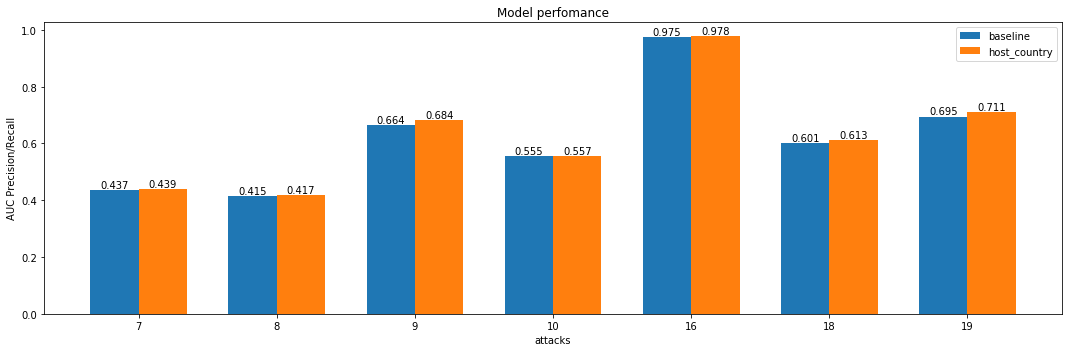

In [44]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.arange(len(x_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, aucs1, width, label=labels[0])
rects2 = ax.bar(x + width/2, aucs2, width, label=labels[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC Precision/Recall')
ax.set_xlabel('attacks')
ax.set_title('Model perfomance')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

# Losdanieles attack

In [24]:
target = 'losdanieles'
table = 'request_sets_y2020_w27'
attack_start = '2020-07-05 14:28:00Z'
attack_stop = '2020-07-05 14:46:00Z'
regular_start = '2020-07-04 14:46:00Z'
regular_stop = '2020-07-05 09:46:00Z'

In [28]:
query = f'(select ip, target, created_at, features, stop, score from request_sets_y2020_w27 where '\
    f'stop > \'{attack_start}\' and stop < \'{attack_stop}\') as attack1'
df = load_dataset(query, spark, config.database)

In [ ]:
df = df.toPandas()

In [34]:
len(df)

69226

In [71]:
attackers = df[df['score'] > 0.45]

In [72]:
len(attackers)

10353

In [73]:
attack_ips = attackers['ip'].unique()

In [74]:
len(attack_ips)

2501

In [75]:
for v in attack_ips:
    print(v)

163.172.211.204
1.20.217.221
113.53.53.138
123.231.239.178
125.26.7.83
139.99.61.158
143.255.142.80
146.120.175.22
150.107.205.196
1.20.156.230
180.149.96.133
180.178.102.174
181.192.2.23
181.62.245.247
165.22.213.55
186.116.226.153
186.145.69.101
176.99.6.196
177.10.193.100
181.10.160.155
181.129.217.53
185.184.243.193
185.255.46.53
176.197.145.162
178.216.2.229
179.9.182.38
185.36.157.30
177.155.215.89
178.159.40.19
178.33.251.230
182.160.119.154
186.96.66.54
186.192.98.250
186.232.119.58
187.45.24.74
181.143.123.118
181.188.201.220
182.253.184.82
184.72.100.4
185.184.243.185
185.255.47.182
189.90.255.208
190.14.249.174
186.72.254.38
186.84.88.135
181.236.249.131
185.184.243.112
185.184.243.176
185.232.66.123
185.43.72.179
188.165.141.114
185.7.77.69
186.102.20.6
190.251.242.96
186.146.200.109
186.154.95.91
190.77.128.177
186.168.137.214
186.219.96.12
188.214.104.146
189.112.176.81
192.99.160.45
186.31.44.213
186.84.22.36
190.103.28.167
190.12.6.138
195.154.112.180
195.154.37.174
195

52.56.251.0
54.176.205.175
61.91.100.34
61.247.10.148
92.52.186.123
94.253.15.25
91.224.182.49
92.62.65.187
54.241.121.74
61.19.35.14
62.201.228.138
66.248.205.6
66.249.64.137
93.183.184.253
62.210.253.15
66.249.70.52
66.249.64.153
67.219.113.93
69.162.66.53
66.249.88.191
69.162.78.170
69.162.82.157
77.247.181.163
69.162.78.173
82.145.221.64
66.249.88.161
69.162.82.155
69.162.82.156
77.87.152.223
85.196.232.166
89.163.227.88
77.232.186.2
81.145.20.214
78.27.182.15
82.114.102.197
83.69.93.64
69.162.66.52
90.189.110.170
84.204.40.154
89.109.64.190
89.134.183.73
85.222.191.222
79.104.197.58
81.15.197.152
89.223.126.70
89.38.97.224
91.192.6.134
91.194.239.122
90.150.52.7
91.93.135.113
95.158.63.46
95.173.185.42
82.215.105.182
88.250.65.219
79.81.217.156
81.93.80.142
81.95.131.10
94.159.74.22
93.159.236.30
95.0.66.117
92.115.134.57
82.163.78.2
99.203.6.49
87.120.253.24
87.120.253.25
105.112.8.53
94.181.52.9
66.96.237.253
109.87.190.3
159.224.248.95
125.16.131.29
128.199.151.20
139.255.89.24

173.252.127.31
186.82.125.243
191.89.247.67
191.95.151.197
181.61.191.32
190.242.27.126
40.77.167.153
188.162.228.121
182.160.99.251
190.25.99.255
191.106.144.161
185.220.101.13
191.91.207.143
77.75.15.246
186.28.219.164
186.84.20.48
191.102.197.86
66.249.76.134
89.144.192.90
186.84.89.35
58.142.201.139
191.156.49.211
200.118.76.111
190.252.175.144
154.100.80.234
37.110.215.173
191.95.147.15
191.95.41.144
139.162.79.88
95.216.40.26
186.112.0.79
186.114.8.191
186.154.120.225
186.154.187.19
51.89.234.97
52.231.163.173
186.169.176.88
114.119.160.235
191.156.41.158
186.154.55.211
191.102.218.81
179.6.221.183
46.217.136.139
54.37.236.65
35.240.117.238
108.80.114.157
173.252.95.2
93.79.104.13
178.34.162.50
190.131.221.34
66.249.70.49
189.136.139.127
102.68.135.57
148.75.235.65
181.54.0.181
66.160.140.183
46.229.168.151
85.141.180.146
125.186.90.130
201.245.210.79
181.199.61.181
66.249.76.136
71.205.89.11
79.81.212.39
186.1.132.86
83.149.21.56
89.223.47.196
181.58.38.53
181.61.167.233
72.30.1

In [76]:
manually_filtered = ['101.109.188.190','101.109.246.40','101.109.255.48','101.200.127.149','101.255.122.73','101.99.7.167','102.130.114.107','102.130.133.102','102.141.197.17','102.164.203.237','102.164.248.60','102.176.160.82','102.176.160.84','102.177.105.34','102.38.50.10','102.67.19.132','102.68.134.32','102.68.134.33','102.68.134.34','102.68.134.35','102.68.134.36','102.68.134.37','102.68.134.38','102.68.134.39','102.68.134.40','102.68.134.41','102.68.134.42','102.68.134.43','102.68.134.44','102.68.134.45','102.68.134.46','102.68.134.47','102.68.134.48','102.68.134.49','102.68.134.50','102.68.134.51','102.68.134.52','102.68.134.53','102.68.134.54','102.68.134.55','102.68.134.56','102.68.134.57','102.68.134.58','102.68.134.59','102.68.134.60','102.68.134.61','102.68.134.62','102.68.134.63','102.68.135.32','102.68.135.33','102.68.135.34','102.68.135.35','102.68.135.36','102.68.135.37','102.68.135.38','102.68.135.39','102.68.135.40','102.68.135.41','102.68.135.42','102.68.135.43','102.68.135.44','102.68.135.45','102.68.135.46','102.68.135.47','102.68.135.48','102.68.135.49','102.68.135.50','102.68.135.51','102.68.135.52','102.68.135.53','102.68.135.54','102.68.135.55','102.68.135.56','102.68.135.57','102.68.135.58','102.68.135.59','102.68.135.60','102.68.135.61','102.68.135.62','102.68.135.63','102.68.17.96','103.101.17.170','103.101.233.13','103.101.83.54','103.105.125.6','103.105.212.106','103.10.54.154','103.10.81.138','103.109.238.250','103.109.59.126','103.111.219.183','103.112.212.194','103.112.58.38','103.114.10.250','103.116.250.78','103.119.230.245','103.120.188.180','103.121.149.46','103.12.161.194','103.122.35.229','103.123.171.2','103.123.231.202','103.123.246.66','103.125.107.220','103.130.112.250','103.130.172.58','103.130.187.98','103.133.222.151','103.134.226.166','103.136.25.43','103.138.226.115','103.138.226.2','103.139.156.122','103.14.111.218','103.14.198.14','103.142.110.130','103.142.68.149','103.142.68.150','103.142.68.154','103.142.68.157','103.142.68.158','103.143.157.42','103.143.84.72','103.146.203.237','103.147.68.251','103.148.195.11','103.148.79.3','103.15.240.89','103.15.60.21','103.16.133.11','103.199.85.58','103.201.140.6','103.20.204.104','103.204.220.18','103.204.220.23','103.208.152.34','103.208.200.114','103.209.131.3','103.209.65.12','103.21.160.10','103.212.92.254','103.216.48.83','103.216.51.210','103.21.93.235','103.220.214.106','103.221.254.125','103.224.38.22','103.227.145.90','103.228.117.244','103.233.152.140','103.233.154.245','103.239.254.114','103.240.161.108','103.245.198.101','103.247.122.102','103.248.13.85','103.250.166.16','103.250.166.4','103.250.69.233','103.251.225.18','103.251.57.23','103.252.117.100','103.26.246.126','103.26.54.94','103.26.55.86','103.28.149.107','103.36.35.131','103.36.48.103','103.36.8.202','103.4.164.205','103.42.162.30','103.42.253.210','103.44.156.62','103.46.233.186','103.47.66.150','103.47.66.42','103.47.67.115','103.47.67.116','103.47.67.123','103.52.144.242','103.53.76.82','103.57.121.132','103.65.26.203','103.66.47.126','103.70.129.130','103.70.145.211','103.70.145.84','103.70.79.2','103.7.27.186','103.76.20.155','103.78.23.26','103.81.214.254','103.81.77.11','103.82.43.118','103.83.118.10','103.86.155.78','103.86.49.193','103.87.160.4','103.91.128.126','103.95.40.211','103.9.88.203','103.99.10.3','103.99.26.2','103.99.8.102','103.99.8.106','104.151.207.71','104.196.240.190','104.196.241.222','104.199.114.40','104.232.196.249','104.238.53.159','104.244.72.99','104.244.73.43','104.244.74.57','104.244.74.97','104.244.75.26','104.244.76.13','104.244.76.245','104.244.77.254','104.248.49.76','105.112.8.53','107.0.255.90','107.77.203.26','107.77.233.71','108.27.220.78','109.167.207.72','109.170.97.146','109.188.74.95','109.199.133.161','109.200.156.102','109.207.94.234','109.251.185.20','109.41.66.89','110.170.254.50','1.10.188.132','1.10.188.140','1.10.188.202','1.10.188.85','110.232.74.51','110.34.3.145','110.36.237.123','110.44.133.135','110.74.219.3','110.76.148.242','110.77.134.106','110.78.147.134','110.78.81.107','110.93.214.36','111.118.154.20','111.67.92.66','111.68.118.121','111.92.240.134','112.109.198.105','1.1.228.77','113.130.126.212','113.160.235.49','113.161.186.101','113.161.58.255','113.163.157.250','113.185.0.13','113.196.140.162','113.53.255.222','113.53.29.218','113.53.53.138','113.53.61.123','113.53.83.157','113.53.83.212','113.53.8.35','113.53.91.214','114.31.15.62','114.4.102.78','114.5.24.14','114.5.35.98','115.127.114.76','115.74.213.139','115.84.99.82','115.85.65.94','116.0.2.162','116.196.85.150','116.197.129.242','116.197.133.90','116.197.134.222','116.203.254.70','116.206.47.10','116.212.109.195','116.212.129.58','116.212.152.64','116.58.254.148','116.66.197.210','116.66.197.228','117.102.105.91','117.102.127.130','117.102.77.3','117.102.78.42','117.103.168.18','117.103.5.186','117.211.203.210','117.2.121.203','117.220.198.251','117.240.238.230','117.4.245.210','117.54.239.18','117.54.4.244','117.58.241.70','1.179.144.181','118.163.13.200','118.172.176.61','118.173.232.219','118.174.196.112','118.174.232.106','118.174.232.243','118.174.233.40','118.175.207.183','118.175.244.111','118.179.119.218','1.186.151.206','118.69.56.68','118.97.100.83','118.97.164.19','118.97.22.203','119.15.82.222','119.15.89.106','119.252.160.165','119.252.161.110','119.252.168.53','119.40.93.26','119.82.242.124','1.20.156.230','1.20.217.221','120.28.57.114','120.29.124.131','120.76.116.167','1.20.97.96','121.52.71.23','12.156.45.155','121.58.246.247','1.2.174.219','122.102.28.160','122.154.72.102','122.200.90.10','122.2.28.114','122.248.45.35','1.2.254.185','122.54.227.188','122.55.250.242','1.229.137.26','123.1.170.138','123.132.232.254','123.139.56.238','123.231.171.11','123.231.239.178','124.105.197.141','124.106.57.182','124.158.154.66','124.158.175.19','124.158.175.2','124.158.175.26','124.41.211.196','124.41.213.211','124.41.240.43','124.6.226.21','124.93.201.59','12.5.154.134','125.16.131.29','125.20.80.178','125.209.235.169','125.209.235.170','125.209.235.175','125.25.206.28','125.25.227.147','125.25.40.37','125.25.80.39','125.26.219.13','125.26.7.114','125.26.7.83','125.27.251.206','125.27.251.24','1.255.48.197','128.199.149.7','128.199.151.20','128.31.0.13','129.205.98.54','131.108.84.14','131.196.202.105','131.196.87.117','131.196.9.216','131.255.186.65','13.231.63.81','134.236.247.137','134.249.167.184','136.243.1.83','136.243.81.120','13.68.172.219','137.220.38.141','137.59.161.46','137.63.184.96','138.121.91.159','138.122.140.18','138.201.248.12','138.201.5.34','138.255.36.199','138.59.25.2','138.68.236.159','139.180.135.7','139.217.110.76','139.228.177.168','139.255.115.139','139.255.13.153','139.255.17.170','139.255.25.106','139.255.31.210','139.255.36.34','139.255.48.164','139.255.74.125','139.255.89.242','139.5.132.245','139.5.71.80','139.99.105.5','139.99.61.158','139.99.90.123','139.99.90.186','140.238.15.65','140.238.17.59','140.82.36.154','140.82.37.12','141.0.180.242','14.102.61.138','14.162.145.116','14.207.12.199','14.207.24.155','14.207.42.220','14.207.60.81','14.225.5.68','142.44.169.101','14.249.164.224','142.93.130.169','142.93.197.142','143.255.142.80','143.255.52.102','144.217.108.11','144.217.166.65','144.91.88.108','144.91.88.111','145.239.121.218','145.239.7.56','146.120.175.22','147.78.160.1','147.78.160.138','147.78.160.192','147.78.160.237','147.78.160.45','147.78.161.119','147.78.161.158','147.78.161.16','147.78.161.169','147.78.161.173','147.78.161.59','147.78.161.94','147.78.161.99','148.251.16.142','148.251.162.204','148.251.56.230','148.251.56.232','149.129.240.8','149.202.238.204','150.107.205.196','150.107.207.137','150.129.250.28','150.129.54.111','150.129.56.138','150.129.8.10','150.129.8.11','150.129.8.12','150.129.8.13','150.129.8.14','150.129.8.15','150.129.8.16','150.129.8.17','150.129.8.23','150.129.8.24','150.129.8.26','150.129.8.27','150.129.8.28','150.129.8.29','150.129.8.30','150.129.8.31','150.129.8.34','150.129.8.4','150.129.8.5','150.129.8.6','150.129.8.7','150.129.8.8','150.129.8.9','151.22.180.54','151.80.237.96','152.204.132.123','152.204.163.30','153.142.70.170','154.0.4.110','154.113.69.154','154.117.143.126','154.120.65.198','154.236.162.58','154.66.125.18','154.73.159.253','156.155.136.11','157.230.155.18','159.192.131.178','159.192.132.220','159.192.140.232','159.192.142.42','159.192.148.58','159.203.44.177','159.203.82.173','159.224.83.100','160.119.44.210','160.119.45.111','161.18.9.253','161.35.15.102','161.38.11.86','162.216.17.140','162.231.236.140','162.247.72.199','162.247.73.192','162.247.74.200','162.247.74.201','162.247.74.204','163.172.125.41','163.172.143.1','163.172.198.72','163.172.202.103','163.172.202.247','163.172.211.204','163.172.60.116','163.172.63.172','163.172.98.140','163.172.98.147','163.172.98.148','163.172.98.153','163.53.185.98','163.53.198.54','163.53.209.7','164.115.22.45','164.132.51.91','164.132.98.80','164.39.202.75','165.16.25.42','165.16.96.92','165.22.211.212','165.22.213.55','165.227.201.107','165.98.139.28','167.0.132.17','167.0.141.192','167.0.82.233','167.233.7.67','167.249.181.19','167.71.238.159','167.71.249.181','167.88.7.134','167.99.226.100','168.138.142.54','168.181.196.71','168.228.193.214','168.228.204.253','168.228.51.238','168.232.20.155','168.90.30.182','169.159.130.182','169.255.126.211','169.255.234.166','170.233.164.192','170.238.236.98','170.81.35.26','170.82.52.48','17.142.157.106','17.142.157.79','171.97.131.30','172.104.11.250','172.104.140.63','172.58.143.39','172.58.203.100','172.58.227.177','173.239.53.9','173.244.209.5','173.252.87.20','173.82.17.187','173.82.17.188','173.82.17.189','173.82.17.190','173.82.62.19','173.82.62.20','173.82.74.60','173.82.74.62','173.82.78.188','173.82.78.189','173.82.78.190','174.193.15.168','175.100.16.20','175.100.73.206','175.106.11.44','175.158.62.142','176.10.107.180','176.103.55.36','176.10.40.102','176.112.157.11','176.115.197.118','176.116.57.51','176.117.126.22','176.120.221.115','176.123.7.19','176.123.9.61','176.192.8.206','176.197.145.162','176.235.99.114','176.30.212.194','176.32.185.22','176.98.76.203','176.99.4.126','176.99.6.196','176.99.9.44','177.10.193.100','177.10.232.124','177.104.82.220','177.124.184.52','177.125.169.6','177.126.81.62','177.128.42.18','177.137.203.179','177.152.143.74','177.155.215.89','177.170.20.74','177.184.140.130','177.200.206.167','177.202.59.58','177.220.188.213','177.22.203.220','177.222.248.168','177.254.19.208','177.255.232.143','177.38.243.102','177.43.217.74','177.43.72.251','177.44.82.232','177.47.181.240','177.55.207.37','177.71.77.202','177.73.170.165','177.74.252.191','177.75.198.61','177.75.8.146','177.8.113.61','177.8.216.114','177.91.72.22','177.99.162.131','177.99.206.82','178.132.220.241','178.151.178.218','178.151.34.43','178.159.40.19','178.16.125.74','178.162.194.7','178.17.170.116','178.17.170.13','178.205.254.106','178.208.131.67','178.210.129.150','178.210.129.228','178.214.12.140','178.215.190.240','178.216.2.229','178.219.118.156','178.238.232.35','178.238.41.102','178.238.41.103','178.238.41.75','178.238.41.79','178.250.92.18','178.32.223.164','178.33.251.230','178.63.105.157','178.63.105.159','178.63.105.161','178.63.105.162','178.63.41.235','178.79.24.36','179.108.81.76','179.12.244.100','179.13.184.8','179.13.87.204','179.14.149.79','179.15.102.143','179.15.149.57','179.15.247.218','179.154.142.141','179.15.92.94','179.1.82.158','179.18.37.221','179.18.48.174','179.189.125.222','179.189.226.186','179.189.27.28','179.222.91.112','179.32.142.178','179.32.217.157','179.33.39.253','179.43.167.229','179.49.117.36','179.49.117.40','179.49.117.41','179.49.117.42','179.49.117.43','179.49.117.45','179.51.112.19','179.51.114.102','179.51.119.60','179.95.235.138','179.97.55.94','180.148.4.194','180.149.96.133','180.178.102.174','180.179.98.22','180.180.170.188','180.180.171.123','180.180.8.34','180.183.1.184','180.183.8.243','180.211.183.178','180.211.186.90','180.211.193.214','180.242.154.60','180.248.254.126','180.250.162.3','180.250.180.66','180.250.216.242','180.250.49.138','180.94.64.114','181.10.129.85','181.10.160.155','181.113.139.197','181.113.225.114','181.114.226.40','181.114.226.44','181.115.38.146','181.118.105.234','181.118.167.73','181.129.103.210','181.129.142.90','181.129.163.74','181.129.165.102','181.129.174.155','181.129.185.132','181.129.217.53','181.129.70.82','181.129.98.146','181.131.134.213','181.132.96.231','181.133.251.222','181.133.96.190','181.136.83.107','181.136.91.93','181.137.198.150','181.139.235.79','181.140.166.162','181.143.123.118','181.143.73.34','181.148.164.226','181.149.243.210','181.154.190.243','181.155.181.39','181.157.46.146','181.168.206.106','181.176.161.39','181.191.180.110','181.192.2.23','181.197.190.201','181.199.38.102','181.225.73.2','181.225.73.229','181.234.163.73','181.234.167.200','181.236.183.5','181.236.228.127','181.236.232.50','181.243.103.146','181.247.191.148','181.247.5.108','181.249.107.167','181.250.107.12','181.251.210.74','181.254.234.100','181.255.144.65','18.130.105.142','18.130.148.154','18.130.19.250','18.130.197.154','18.130.234.227','18.130.246.154','18.130.57.185','18.130.68.164','18.130.98.75','18.132.118.75','18.132.60.113','181.33.177.112','18.133.27.60','18.133.28.120','18.133.29.238','18.133.29.32','18.133.32.184','18.133.33.88','181.39.32.122','181.39.44.242','181.39.48.2','181.44.84.32','181.48.161.194','181.48.88.237','181.49.131.82','181.50.193.245','181.51.176.91','181.51.32.229','181.52.172.253','181.52.222.185','181.52.253.159','181.53.11.25','181.53.152.71','181.54.106.87','181.54.1.8','181.54.210.102','181.54.83.61','181.56.184.94','181.56.249.49','181.56.72.114','181.57.195.101','181.57.87.222','181.58.146.17','181.58.243.200','181.58.243.252','181.58.38.132','181.59.241.63','181.60.108.148','181.60.240.81','181.61.18.34','181.61.208.222','181.61.209.39','181.61.43.23','181.61.56.223','181.61.81.148','181.62.10.63','181.62.245.247','181.65.186.227','181.78.10.232','181.78.1.202','181.78.2.114','181.78.5.14','18.185.237.34','18.209.171.103','18.210.3.247','182.160.104.213','182.160.104.22','182.160.119.154','182.160.99.251','182.16.255.194','18.220.1.250','18.221.178.139','182.23.35.242','182.253.114.66','182.253.115.138','182.253.163.139','182.253.184.82','182.253.244.137','182.253.31.152','182.253.89.107','18.233.206.44','182.48.89.149','182.50.255.194','182.52.229.165','182.53.197.156','182.53.197.223','182.53.206.40','182.75.130.222','182.93.80.28','183.207.194.206','183.207.194.210','183.88.169.126','183.88.212.141','183.89.116.199','183.89.176.170','184.177.109.10','184.73.145.223','184.82.128.211','185.100.87.41','185.107.80.224','185.107.83.71','185.111.248.21','185.12.45.114','185.128.38.149','185.132.228.118','185.136.243.185','185.138.123.78','185.14.248.98','185.161.209.205','185.165.168.229','185.175.208.180','185.184.243.111','185.184.243.112','185.184.243.113','185.184.243.116','185.184.243.117','185.184.243.119','185.184.243.121','185.184.243.122','185.184.243.173','185.184.243.176','185.184.243.178','185.184.243.185','185.184.243.193','185.184.243.196','185.184.243.198','185.184.243.8','185.184.243.9','185.187.197.122','185.188.218.10','185.189.211.70','185.200.36.105','185.200.36.120','185.20.198.106','185.20.6.73','185.20.6.75','185.208.172.252','185.213.155.169','185.214.76.203','185.220.100.240','185.220.100.241','185.220.100.242','185.220.100.243','185.220.100.244','185.220.100.245','185.220.100.246','185.220.100.248','185.220.100.249','185.220.100.251','185.220.100.252','185.220.100.253','185.220.100.254','185.220.100.255','185.220.101.1','185.220.101.10','185.220.101.11','185.220.101.13','185.220.101.130','185.220.101.131','185.220.101.132','185.220.101.134','185.220.101.136','185.220.101.137','185.220.101.138','185.220.101.139','185.220.101.14','185.220.101.140','185.220.101.141','185.220.101.142','185.220.101.143','185.220.101.144','185.220.101.146','185.220.101.15','185.220.101.157','185.220.101.16','185.220.101.162','185.220.101.17','185.220.101.173','185.220.101.18','185.220.101.19','185.220.101.193','185.220.101.194','185.220.101.2','185.220.101.205','185.220.101.209','185.220.101.21','185.220.101.229','185.220.101.23','185.220.101.235','185.220.101.24','185.220.101.26','185.220.101.28','185.220.101.29','185.220.101.3','185.220.101.31','185.220.101.33','185.220.101.4','185.220.101.5','185.220.101.6','185.220.101.8','185.220.103.4','185.220.103.7','185.229.236.176','185.232.52.100','185.232.52.64','185.232.66.123','185.232.66.124','185.232.66.127','185.250.149.247','185.35.202.222','185.36.157.30','185.38.175.71','185.41.154.18','185.42.60.242','185.43.72.179','185.44.232.30','185.58.14.193','185.64.16.117','185.66.128.245','185.7.77.67','185.7.77.68','185.7.77.69','185.7.77.70','185.83.197.227','185.88.173.45','185.88.173.47','185.88.173.48','185.90.161.178','185.90.161.180','185.90.161.182','185.99.124.130','186.0.104.88','186.0.72.121','186.102.13.57','186.102.188.106','186.102.19.218','186.102.19.60','186.102.21.123','186.102.22.0','186.102.23.177','186.102.25.140','186.102.33.85','186.102.35.143','186.102.36.236','186.102.37.189','186.102.4.129','186.102.4.50','186.102.60.193','186.102.6.192','186.102.67.160','186.102.86.129','186.102.9.218','186.102.96.147','186.102.96.231','186.103.130.91','186.112.125.0','186.112.186.180','186.112.45.224','186.113.107.28','186.113.241.190','186.1.139.196','186.114.21.142','186.114.244.77','186.114.51.158','186.118.227.102','186.118.232.250','186.118.23.243','186.118.249.105','186.1.183.66','186.118.4.251','186.119.179.14','186.119.50.84','186.119.75.239','186.144.130.251','186.146.112.160','186.146.121.151','186.148.169.34','186.148.184.220','186.154.100.1','186.154.156.16','186.154.36.180','186.154.39.131','186.154.41.7','186.154.55.223','186.154.85.49','186.15.49.12','186.155.12.49','186.155.15.128','186.155.44.246','186.168.12.113','186.168.136.239','186.168.189.209','186.168.197.152','186.168.49.165','186.168.6.76','186.169.129.34','186.169.133.41','186.169.136.201','186.169.14.224','186.169.152.3','186.169.167.253','186.169.171.192','186.169.172.164','186.169.188.186','186.170.206.53','186.190.224.100','186.192.195.211','186.192.253.42','186.192.98.250','186.193.181.102','186.219.96.12','186.220.64.64','186.225.157.22','186.228.147.58','186.229.25.196','186.232.119.58','186.232.48.98','186.233.104.164','186.235.157.0','186.235.157.1','186.235.157.13','186.235.157.20','186.235.157.21','186.235.157.23','186.235.157.29','186.235.157.3','186.235.157.4','186.235.157.42','186.235.157.44','186.235.157.51','186.235.157.52','186.235.157.58','186.235.86.22','186.251.95.155','186.28.163.78','186.28.177.22','186.28.20.130','186.28.212.156','186.28.27.186','186.28.33.125','186.28.33.221','186.28.34.54','186.28.82.30','186.28.99.57','186.29.110.155','186.29.165.167','186.29.170.73','186.29.183.12','186.29.190.81','186.29.213.8','186.29.228.147','186.29.83.245','186.29.87.171','186.29.8.96','186.30.107.104','186.31.146.171','186.31.154.48','186.31.171.145','186.31.180.21','186.31.188.237','186.31.3.162','186.31.55.62','186.31.97.26','186.42.121.140','186.46.130.222','186.46.184.182','186.46.3.238','186.47.82.138','186.72.254.38','186.80.100.200','186.80.6.117','186.81.149.76','186.81.187.150','186.81.235.82','186.81.77.210','186.81.83.163','186.82.132.16','186.82.17.61','186.83.207.178','186.83.23.131','186.83.5.57','186.83.64.237','186.84.174.199','186.84.20.125','186.84.20.230','186.84.21.20','186.84.22.99','186.84.65.134','186.84.88.151','186.84.89.14','186.84.89.2','186.84.89.250','186.84.90.164','186.84.92.196','186.85.113.14','186.85.204.54','186.85.40.38','186.86.215.123','186.86.231.119','186.86.32.166','186.86.33.139','186.86.33.31','186.86.33.34','186.86.83.121','186.87.247.55','186.87.8.64','186.90.96.36','186.96.66.54','187.109.36.251','187.1.174.94','187.120.253.119','187.125.23.26','187.130.75.77','187.135.69.141','187.188.168.57','187.190.116.87','187.190.237.131','187.19.102.22','187.191.4.88','187.44.1.167','187.44.1.172','187.44.233.190','187.45.24.74','187.45.54.98','187.6.108.42','187.62.195.145','187.62.209.155','187.62.213.110','187.62.223.193','187.6.8.138','187.94.16.59','187.94.221.0','188.127.226.184','188.127.229.53','188.127.229.8','188.133.173.21','188.133.192.164','188.165.141.114','188.165.16.230','188.173.225.165','188.187.0.158','188.191.165.92','188.210.250.212','188.214.104.146','188.225.177.82','188.68.240.144','188.68.240.147','188.94.224.82','189.112.176.81','189.11.248.162','189.1.152.243','189.203.133.233','189.203.8.179','189.237.132.191','189.80.3.187','189.89.248.40','189.90.255.208','190.102.58.181','190.103.28.167','190.11.15.14','190.119.187.194','190.121.146.3','190.12.6.138','190.127.196.236','190.127.196.67','190.128.54.33','190.12.95.170','190.130.120.73','190.130.121.189','190.130.122.161','190.130.122.209','190.130.65.82','190.130.66.233','190.130.67.70','190.130.82.205','190.130.82.234','190.130.87.66','190.130.88.174','190.130.89.49','190.130.93.162','190.141.197.189','190.14.249.174','190.144.217.5','190.144.250.167','190.147.217.226','190.156.130.126','190.156.131.90','190.159.152.150','190.171.180.162','190.204.90.95','190.210.15.194','190.214.27.46','190.214.30.146','190.216.179.227','190.217.29.2','190.234.155.151','190.24.176.217','190.243.210.24','190.247.199.166','190.248.126.92','190.248.135.106','190.248.153.162','190.24.97.185','190.251.155.87','190.25.121.246','190.25.166.203','190.253.192.32','190.255.100.18','190.25.70.5','190.25.91.43','190.26.230.29','190.27.89.181','190.29.152.167','190.52.194.122','190.63.184.11','190.63.224.22','190.67.243.86','190.68.37.98','190.69.63.247','190.70.229.176','190.7.154.146','190.73.4.197','190.80.11.32','190.8.243.99','190.83.76.130','190.84.116.19','190.84.117.50','190.84.2.136','190.84.65.92','190.85.115.78','190.85.147.122','190.90.234.14','190.90.45.2','190.96.214.59','190.96.227.158','190.99.142.81','190.99.167.210','190.99.197.75','190.99.198.10','191.100.24.251','191.102.120.225','191.102.127.173','191.102.197.45','191.102.198.193','191.102.220.22','191.102.220.38','191.102.221.1','191.102.222.32','191.103.219.129','191.106.137.157','191.106.139.52','191.106.152.168','191.106.160.201','191.106.179.74','191.106.184.120','191.106.190.186','191.106.190.36','191.156.11.165','191.156.24.227','191.156.25.52','191.156.26.255','191.156.26.28','191.156.27.50','191.156.30.209','191.156.31.245','191.156.48.96','191.156.49.80','191.156.50.228','191.156.5.112','191.156.51.240','191.156.55.45','191.156.59.69','191.156.60.163','191.156.60.29','191.156.64.209','191.156.67.26','191.156.69.70','191.156.7.171','191.156.72.181','191.156.74.130','191.156.76.249','191.156.77.123','191.240.17.204','191.242.230.135','191.65.118.164','191.68.17.81','191.73.251.58','191.91.91.212','191.95.132.124','191.95.142.3','191.95.148.248','191.95.148.3','191.95.150.184','191.95.17.39','191.95.18.60','191.95.25.49','191.95.26.154','191.95.32.231','191.95.34.109','191.95.34.249','191.95.40.48','191.95.41.252','191.95.43.158','191.95.48.129','191.95.49.7','191.95.50.217','191.95.50.231','191.95.56.91','191.95.57.231','191.95.57.95','191.95.58.117','191.95.58.86','191.98.119.212','191.98.90.124','192.248.150.173','192.42.116.23','192.42.116.25','192.99.160.45','193.106.130.249','193.106.192.149','193.106.94.106','193.108.117.189','193.108.117.57','193.124.178.146','193.148.67.106','193.150.117.3','193.169.188.21','193.169.20.100','193.169.20.102','193.169.20.98','193.169.20.99','193.176.212.195','193.218.118.130','193.218.118.140','193.218.118.80','193.233.158.136','193.57.137.245','193.8.46.22','193.86.229.230','193.93.76.167','194.116.229.62','194.135.42.74','194.156.101.48','194.55.167.12','194.58.36.241','194.58.36.245','194.58.36.249','194.58.36.251','194.58.38.206','194.58.38.72','194.58.40.245','194.61.138.12','194.79.63.134','194.8.146.167','195.144.21.219','195.154.112.151','195.154.112.169','195.154.112.180','195.154.112.34','195.154.112.50','195.154.233.184','195.154.252.205','195.154.253.136','195.154.34.145','195.154.37.174','195.154.38.105','195.154.42.163','195.154.46.171','195.154.47.198','195.154.47.233','195.154.47.39','195.154.47.52','195.154.48.227','195.154.52.142','195.154.55.211','195.154.57.243','195.170.15.66','195.176.3.19','195.176.3.20','195.178.102.107','195.178.102.141','195.201.245.126','195.206.105.217','195.206.51.98','195.208.250.22','195.218.155.98','195.22.148.4','195.22.148.5','195.22.148.8','195.239.187.14','195.24.49.142','195.24.53.195','195.37.242.138','195.4.164.127','195.69.218.198','195.82.116.96','195.9.114.222','195.9.162.186','195.9.173.38','195.98.78.43','196.0.34.142','196.3.97.86','197.159.70.129','197.211.238.220','197.232.36.43','197.81.195.200','198.204.232.125','198.229.231.13','198.251.83.193','198.58.10.149','198.98.50.164','198.98.51.240','198.98.54.241','198.98.55.168','198.98.56.71','198.98.58.178','199.195.248.24','199.195.250.77','199.217.117.41','199.247.28.177','199.249.230.102','199.249.230.106','199.249.230.144','199.249.230.187','199.249.230.69','199.249.230.72','200.101.66.170','200.105.215.18','200.106.139.250','200.10.65.89','200.108.183.2','200.108.59.97','200.115.48.82','200.118.117.100','200.122.209.70','200.127.155.86','200.16.208.187','200.183.80.178','200.186.98.234','200.188.151.212','200.199.38.234','200.206.50.66','200.206.92.158','200.215.171.238','200.216.115.10','200.219.152.226','200.255.122.170','200.29.109.111','200.29.126.214','200.37.231.66','200.50.167.67','200.5.203.58','200.54.22.74','200.54.247.98','200.6.179.236','200.6.185.206','200.69.71.102','201.182.250.226','201.20.107.94','201.217.247.134','201.229.164.89','201.232.211.123','201.233.197.39','201.237.55.8','201.245.214.209','201.46.28.222','201.48.165.189','201.52.56.62','201.83.68.162','201.94.203.179','202.134.191.156','202.137.25.8','202.137.28.90','202.138.239.183','202.138.239.84','202.138.248.107','202.138.248.187','202.138.248.85','202.138.249.214','202.142.155.250','202.143.120.25','202.143.122.119','202.146.178.227','202.147.196.131','202.152.24.50','202.152.27.75','202.153.233.228','202.154.190.234','202.162.198.93','202.162.208.11','202.162.214.243','202.166.196.34','202.166.205.78','202.166.220.150','202.169.255.7','202.169.51.44','202.169.56.2','202.182.52.74','202.182.57.10','202.29.223.226','202.29.223.34','202.40.177.234','202.40.177.66','202.53.87.62','202.5.48.132','202.5.57.2','202.57.2.19','202.57.35.74','202.57.55.178','202.62.103.204','202.65.171.67','202.65.173.26','202.70.84.1','202.72.233.18','203.112.212.98','203.130.227.189','203.130.23.250','203.150.172.151','203.160.63.157','203.176.133.38','203.176.135.98','203.190.53.107','203.192.229.250','203.202.248.35','203.45.16.197','203.76.150.50','203.81.91.80','203.95.220.141','204.194.29.4','204.236.210.97','205.185.115.100','205.185.116.235','205.185.117.149','205.185.127.219','205.185.127.8','208.255.161.107','208.68.37.40','208.72.145.14','209.141.46.47','209.141.49.11','209.141.52.48','209.190.32.28','209.212.33.99','209.250.238.7','209.41.69.101','210.103.3.169','210.1.82.194','210.21.68.60','210.245.54.97','210.56.245.77','210.61.240.158','211.21.120.163','212.126.122.118','212.129.29.156','212.129.34.74','212.129.8.121','212.156.55.34','212.170.177.89','212.200.238.190','212.243.94.98','212.32.229.227','212.34.250.14','212.42.113.240','212.46.1.174','212.47.229.4','212.83.128.9','212.83.150.241','212.83.153.143','212.83.154.167','212.83.154.189','212.83.165.43','212.83.167.199','212.83.167.35','212.83.168.189','212.83.168.87','212.83.169.10','212.83.169.144','212.83.170.132','212.83.173.50','212.83.174.43','212.83.178.54','212.83.180.30','212.83.183.17','212.83.183.29','212.83.188.253','212.92.204.54','212.98.143.138','213.136.64.119','213.136.64.120','213.136.64.121','213.150.206.29','213.154.0.120','213.163.113.96','213.174.10.58','213.234.238.52','213.6.101.174','213.6.28.66','213.6.65.30','2.139.189.242','216.74.38.68','217.163.28.38','217.170.205.14','217.170.206.138','217.172.190.243','217.174.149.228','217.174.149.245','217.182.168.153','217.23.69.146','217.28.82.85','218.25.39.34','218.27.136.169','218.60.8.99','220.247.174.12','221.122.91.74','221.122.91.75','221.5.80.66','222.124.154.19','222.124.193.113','222.252.156.61','222.252.25.168','223.204.155.74','223.25.97.210','23.129.64.100','23.129.64.181','23.129.64.184','23.129.64.185','23.129.64.187','23.129.64.191','23.129.64.193','23.129.64.196','23.129.64.197','23.129.64.200','23.129.64.202','23.129.64.205','23.129.64.209','23.129.64.210','23.129.64.211','23.129.64.213','23.129.64.215','23.129.64.216','23.129.64.217','24.113.38.57','24.113.42.177','27.113.241.87','27.116.51.115','27.124.85.126','27.147.219.46','27.191.234.69','27.255.58.55','27.255.58.72','27.72.29.159','3.10.59.99','31.13.103.111','31.13.127.15','31.13.127.5','31.220.2.131','3.125.229.126','3.208.3.98','3.212.171.155','3.218.13.9','3.222.200.159','34.105.116.187','34.105.30.21','34.125.152.121','34.195.153.91','34.202.81.205','34.204.89.78','34.222.87.153','34.228.233.215','34.229.165.223','34.238.143.212','34.239.45.24','34.82.101.136','34.82.231.53','34.83.140.24','34.83.166.167','34.83.20.6','34.83.239.192','34.83.240.112','34.83.248.254','34.83.28.253','34.83.7.203','34.83.81.192','34.83.94.66','34.87.218.176','34.91.224.196','34.91.232.226','34.94.90.93','35.176.109.179','35.177.151.161','35.177.190.226','35.177.31.98','35.178.136.114','35.178.166.233','35.178.168.161','35.178.205.194','35.179.91.165','35.179.94.126','35.179.94.80','35.179.95.180','35.185.238.24','35.185.240.9','35.197.44.200','35.197.5.49','35.197.74.198','35.197.8.100','35.197.89.37','35.197.96.101','35.197.96.26','35.197.99.247','35.199.144.147','35.199.155.118','35.202.9.41','35.203.135.108','35.203.139.96','35.203.175.167','35.227.144.38','35.227.178.2','35.227.181.247','35.227.184.95','35.229.213.239','35.230.118.4','35.230.36.4','35.230.74.130','35.233.128.237','35.233.155.91','35.233.175.47','35.233.177.167','35.233.201.223','35.233.209.129','35.247.45.149','35.247.46.10','35.247.51.208','35.247.55.85','35.247.89.146','35.247.93.30','36.112.139.146','36.37.113.4','36.37.81.135','36.65.79.13','36.66.107.219','36.66.127.99','36.66.19.10','36.66.206.74','36.66.220.19','36.66.61.119','36.67.109.91','36.67.116.165','36.67.143.183','36.67.198.35','36.67.206.187','36.67.20.71','36.67.209.35','36.67.57.45','36.67.76.234','36.72.161.175','36.74.124.141','36.75.222.81','36.75.254.196','36.81.255.22','36.82.104.21','36.89.148.161','36.89.188.123','36.89.193.29','36.89.230.143','36.89.234.175','36.89.28.250','36.89.8.235','36.90.5.39','36.91.109.34','36.91.129.18','36.91.148.36','36.91.160.171','36.91.219.170','36.91.32.27','36.91.51.233','36.92.106.169','36.92.107.194','36.92.180.240','36.92.18.179','36.92.197.189','36.92.209.133','36.92.35.73','36.92.68.177','36.92.70.209','36.92.74.203','36.92.91.50','36.92.93.43','36.92.93.61','36.94.8.23','37.130.38.21','37.157.254.72','37.157.254.99','37.172.0.115','37.193.255.82','37.228.129.2','37.228.68.27','37.247.209.179','37.26.86.206','3.8.121.195','3.8.132.124','3.8.153.70','3.8.163.156','3.8.166.121','3.8.180.102','3.8.181.178','3.8.181.226','3.8.188.9','3.8.198.82','3.8.202.40','38.21.34.224','3.8.33.118','3.88.57.31','38.90.33.10','3.89.138.241','3.8.94.24','39.109.123.188','3.92.251.21','3.9.24.139','39.37.141.191','40.65.136.31','40.85.189.146','40.90.176.122','41.139.9.47','41.164.247.186','41.170.84.218','41.190.92.99','41.191.216.189','41.220.114.154','41.223.143.78','41.254.46.103','41.33.179.195','4.14.219.157','41.60.216.176','41.60.232.255','41.63.170.142','41.72.199.6','41.75.123.49','41.75.85.22','41.79.197.150','41.79.66.106','41.86.251.62','42.112.34.29','42.112.34.31','43.225.186.18','43.228.131.115','43.241.30.2','43.242.242.196','43.243.166.222','43.245.202.15','43.245.216.28','43.245.216.69','43.250.127.98','43.252.145.50','43.252.238.46','43.255.22.195','45.115.63.78','45.119.203.171','45.127.48.241','45.129.56.200','45.134.29.243','45.137.184.71','45.159.75.230','45.168.252.49','45.169.16.13','45.175.139.89','45.175.166.35','45.177.145.235','45.177.215.78','45.177.233.106','45.181.224.18','45.229.29.1','45.230.242.28','45.233.64.240','45.236.171.82','45.238.54.115','45.248.139.140','45.250.226.48','45.250.226.56','45.32.226.218','45.33.84.82','45.4.237.72','45.4.253.155','45.70.196.132','45.71.108.18','45.71.114.146','45.71.160.114','45.71.184.132','45.7.134.198','45.76.147.236','45.76.238.109','45.76.83.137','45.77.141.163','45.79.135.19','45.79.143.138','46.146.220.173','46.148.213.195','46.150.170.10','46.165.230.5','46.165.239.26','46.165.245.154','46.165.251.100','46.165.251.102','46.165.251.103','46.166.139.111','46.167.244.161','46.167.244.165','46.167.244.166','46.171.2.210','46.173.211.225','46.174.234.166','46.19.141.84','46.197.209.217','46.198.141.82','46.20.59.11','46.219.85.64','46.221.1.68','46.221.57.62','46.232.251.191','46.254.217.54','46.38.235.14','46.45.185.30','46.45.185.39','46.52.148.90','46.52.214.216','46.52.255.69','46.73.33.253','46.8.10.56','46.8.28.17','47.102.210.165','47.41.117.44','47.92.0.27','49.156.42.188','49.156.45.227','49.231.159.165','50.116.52.220','50.235.149.74','51.15.106.64','51.15.148.249','51.15.166.232','51.15.173.125','51.15.173.82','51.15.182.229','51.15.187.231','51.15.188.117','51.15.188.15','51.15.188.61','51.15.235.211','51.15.80.14','51.158.111.157','51.158.119.88','51.158.31.131','51.158.31.137','51.158.31.139','51.159.28.193','51.159.66.217','51.210.34.150','51.254.237.77','51.254.35.77','51.255.45.144','51.255.77.78','5.129.110.73','5.149.205.10','5.15.17.119','5.16.0.79','5.16.10.226','51.68.139.151','51.68.61.17','51.75.144.43','51.75.144.58','51.75.164.68','51.77.108.33','51.77.135.89','51.77.52.11','51.79.161.3','51.79.53.139','51.79.53.146','51.79.86.174','51.79.86.177','51.89.23.74','51.91.118.57','51.91.201.55','51.91.212.159','52.15.189.16','52.179.18.244','52.45.53.95','5.249.152.107','5.249.152.109','5.252.23.29','52.56.123.168','52.56.123.26','52.56.136.68','52.56.186.149','52.56.211.154','52.56.247.59','52.56.251.0','52.60.130.237','52.87.196.230','52.91.69.31','54.145.42.57','54.152.181.140','54.158.211.65','54.164.177.168','54.175.186.38','54.191.139.127','54.194.138.208','54.241.121.74','54.249.53.213','54.38.81.231','54.39.16.73','54.76.120.237','54.80.218.180','54.82.220.255','54.83.51.193','54.90.194.228','54.94.167.229','5.56.133.225','5.58.50.5','5.58.52.231','5.58.58.209','5.58.88.175','5.59.141.152','58.145.170.202','58.185.160.30','58.215.213.228','58.220.95.55','58.220.95.78','58.220.95.79','58.220.95.86','58.58.213.55','58.61.154.153','58.69.88.226','58.8.143.7','58.96.150.62','58.97.72.83','60.251.195.198','60.53.199.121','61.153.251.150','61.19.35.14','61.247.10.148','61.247.10.166','61.91.100.34','61.91.183.86','62.102.148.68','62.118.131.240','62.171.177.80','62.176.12.111','62.176.15.169','62.201.228.138','62.210.136.217','62.210.211.94','62.210.253.15','62.69.214.130','63.151.67.7','64.188.3.162','64.217.149.6','64.43.154.88','64.56.218.163','64.71.145.122','64.9.251.144','65.152.119.226','66.102.7.250','66.102.9.128','66.220.149.111','66.229.31.229','66.248.205.3','66.248.205.4','66.248.205.6','66.249.88.160','66.249.93.98','66.96.237.253','67.219.113.93','67.219.116.234','67.52.84.206','67.73.245.122','68.82.179.87','68.96.37.84','69.162.66.50','69.162.66.52','69.162.66.53','69.162.66.54','69.162.78.170','69.162.78.171','69.162.78.172','69.162.78.173','69.162.78.174','69.162.82.155','69.162.82.156','69.162.82.157','69.162.82.158','69.164.221.23','69.171.251.21','69.202.252.122','69.222.158.162','70.169.145.164','70.169.149.231','70.169.150.183','70.49.8.180','71.168.222.78','71.91.230.226','73.0.56.132','73.170.204.219','74.208.112.84','74.85.156.94','75.151.213.85','76.110.245.214','76.110.34.124','76.31.128.51','77.120.113.64','77.120.137.143','77.202.57.114','77.232.186.2','77.237.121.19','77.247.127.45','77.247.181.162','77.247.181.163','77.247.181.165','77.247.94.130','77.28.97.78','77.37.131.164','77.87.152.223','77.93.42.134','77.94.112.234','78.140.7.239','78.168.73.173','78.188.173.54','78.25.68.145','78.30.198.160','78.47.150.43','78.8.45.68','78.84.70.245','79.101.106.74','79.104.197.58','79.133.182.2','79.164.171.32','79.174.184.204','79.81.217.156','80.243.158.6','80.244.239.21','80.250.20.190','80.28.102.26','80.67.172.162','80.78.74.133','80.87.201.64','80.87.202.247','80.87.217.6','81.1.213.36','81.145.20.214','81.15.197.152','81.162.243.249','81.17.131.59','81.17.16.149','81.93.80.142','81.95.131.10','82.114.102.197','82.137.244.151','82.150.177.19','82.163.78.2','82.200.233.4','82.221.131.5','83.167.73.151','83.69.93.64','84.15.143.111','84.201.254.47','84.204.40.154','84.209.141.235','85.105.38.147','85.198.185.26','85.222.191.222','85.234.126.107','85.248.227.163','85.248.227.164','85.248.227.165','86.123.166.109','86.62.120.68','87.120.253.131','87.120.253.132','87.120.253.133','87.120.253.24','87.120.253.25','87.252.254.24','88.198.36.15','88.205.232.66','88.250.65.219','88.85.246.20','88.87.79.20','88.99.144.143','88.99.144.159','89.107.197.118','89.108.112.2','89.108.112.5','89.109.64.190','89.134.183.73','89.163.227.88','89.163.239.216','89.175.188.58','89.204.214.142','89.208.35.81','89.218.5.106','89.22.17.62','89.223.126.70','89.223.126.72','89.234.157.254','89.237.29.198','89.250.152.76','89.250.17.192','89.250.221.106','89.28.164.55','89.31.46.208','89.36.68.103','89.38.97.224','89.38.97.225','89.38.97.228','89.40.124.229','90.150.52.7','90.188.35.190','90.189.110.170','91.132.147.168','91.132.174.218','91.143.218.146','91.165.135.81','91.192.6.134','91.194.239.122','91.194.247.247','91.202.240.208','91.203.176.204','91.206.110.190','91.206.30.218','91.207.238.193','91.210.136.202','91.214.128.243','91.214.31.234','91.217.202.174','91.217.42.64','91.224.182.49','91.225.11.51','91.236.61.65','91.239.132.253','91.240.97.69','91.244.252.237','91.67.240.45','91.93.135.113','92.115.134.57','92.118.90.186','92.245.142.215','92.247.93.142','92.51.149.81','92.52.186.123','92.62.65.187','93.113.207.105','93.153.173.102','93.159.236.30','93.174.94.80','93.183.184.253','93.87.44.242','93.88.216.51','93.92.51.141','93.99.176.84','94.130.53.35','94.140.208.226','94.158.152.54','94.159.74.22','94.16.121.91','94.179.135.230','94.181.52.9','94.21.118.140','94.230.208.147','94.230.208.148','94.243.63.14','94.25.104.250','94.253.15.25','94.28.29.57','94.28.78.248','94.28.93.117','94.30.97.245','94.51.83.2','94.56.101.198','94.75.76.10','95.0.66.102','95.0.66.109','95.0.66.117','95.0.66.69','95.104.54.227','95.140.18.238','95.142.219.181','95.158.63.46','95.163.87.74','95.165.252.94','95.167.150.166','95.173.179.63','95.173.185.189','95.173.185.42','95.179.182.151','95.211.230.211','95.215.48.93','95.217.209.121','95.58.161.180','95.80.254.85','96.234.61.104','96.9.67.84','98.242.133.54','98.249.146.54','99.192.170.249','99.237.120.8']

In [77]:
len(list(set(manually_filtered) & set(attack_ips)))

1298